# E2: moment tracking validation ($\hat m_t$ vs. $\bar x_t^{(*)}$)

This notebook implements **E2** from Appendix B.2.

We simulate the guided SDE (with **unit diffusion**)
$$\mathrm{d}X_t = u_t^{(*)}(X_t)\,\mathrm{d}t + \mathrm{d}W_t,\qquad X(0)=0,$$
and compare the **empirical mean**
$$\hat m_t=\frac{1}{N}\sum_{n=1}^N X_t^{(n)}$$
to the **analytic mean** $\bar x_t^{(*)}$ computed by `field.xbar_star(t)`.

The comparison is low-variance and complements the snapshot-based E1 test.


In [1]:
# -----------------------------------------------------------------------------
# Imports and module wiring (hardwired root)
# -----------------------------------------------------------------------------
import sys
from pathlib import Path
import numpy as np
import torch

ROOT = Path(r"/Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks")


if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

device = torch.device("cpu")
dtype  = torch.float64

print("Repo ROOT:", ROOT)
print("device:", device, "dtype:", dtype)

from guided_continuous import PWCProtocol, ContinuousCoeffs, GaussianMixture

Repo ROOT: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks
device: cpu dtype: torch.float64


## Imports
We reuse the same package wiring as in **E1** (hardwired `ROOT`), and then import the analytic field and the Euler–Maruyama simulator.


In [2]:
import math
import matplotlib.pyplot as plt
import torch

from guided_continuous import PWCProtocol, ContinuousCoeffs, GaussianMixture, GuidedField, euler_maruyama_guided, heun_guided, TimeDomain

plt.rcParams["figure.dpi"] = 130


## Define a generic 2D test problem
We construct:
1. A **non-degenerate PWC protocol** with a few breakpoints.
2. A **2D Gaussian mixture** in general position.
3. The continuous coefficients and the `GuidedField`.

We also enforce an interior-time policy $t\in[\varepsilon,1-\varepsilon]$ via `TimeDomain(eps=1e-4)` to avoid singular behavior as $t\to 1$.


In [3]:
# -----------------------------------------------------------------------------
# Safe SPD constructors for 2x2 covariances + a "general position" 2D GM example
# -----------------------------------------------------------------------------
import torch

def make_spd_2x2(A, jitter=0.20, *, dtype=torch.float64, device="cpu"):
    """Guaranteed SPD: Sigma = A A^T + jitter * I, with symmetry enforced."""
    A = torch.as_tensor(A, dtype=dtype, device=device)
    S = A @ A.T
    S = 0.5 * (S + S.T)
    S = S + jitter * torch.eye(2, dtype=dtype, device=device)
    return S

def rot(theta, *, dtype=torch.float64, device="cpu"):
    """2D rotation matrix."""
    th = torch.as_tensor(theta, dtype=dtype, device=device)
    c, s = torch.cos(th), torch.sin(th)
    return torch.stack([torch.stack([c, -s]),
                        torch.stack([s,  c])], dim=0)

def spd_from_axes(theta, lam1=0.15, lam2=0.60, *, dtype=torch.float64, device="cpu", jitter=1e-6):
    """SPD ellipse covariance via rotated principal axes."""
    R = rot(theta, dtype=dtype, device=device)
    D = torch.diag(torch.as_tensor([lam1, lam2], dtype=dtype, device=device))
    S = R @ D @ R.T
    S = 0.5 * (S + S.T) + jitter * torch.eye(2, dtype=dtype, device=device)
    return S


def make_example(*, B: int = 6000, n_steps: int = 2500, seed: int = 1, device=None, dtype=None, eps: float = 1e-3):
    """Construct a generic 2D test instance (protocol + target GM + field).

    Notes:
      * We enforce an interior time policy t in [eps, 1-eps] globally (TimeDomain).
      * Covariances are SPD by construction to avoid numerical Cholesky failures.
    """
    if dtype is None:
        dtype = torch.float64
    if device is None:
        device = torch.device("cpu")  # switch to torch.device("cuda") for GPU

    time_domain = TimeDomain(eps=eps)

    # --- PWC protocol (simple but non-degenerate) ---
    """breaks = torch.tensor([0.0, 0.35, 0.70, 1.0], dtype=dtype, device=device)
    beta_vals = torch.tensor([1.0, 2.0, 1.2], dtype=dtype, device=device)  # (M,)
    nu_vals = torch.tensor([[0.1, 0.5],
                            [0.6, 0.05],
                            [1., 1.0]], dtype=dtype, device=device)      # (M,d)"""

    breaks = torch.tensor([0.0, 0.2, 0.50, 0.75, 1.0], dtype=dtype, device=device)
    beta_vals = torch.tensor([5.0, 4.0, 3.0, 1.0], dtype=dtype, device=device)  # (M,)
    nu_vals = torch.tensor([[0.0, 0.0],
                            [0.4, 0.06],
                            [1.5, 0.2], 
                            [1.2, 0.18]], dtype=dtype, device=device)      # (M,d)

    beta = PWCProtocol(breaks, beta_vals, time_domain=time_domain)
    nu   = PWCProtocol(breaks, nu_vals,  time_domain=time_domain)

    # --- Target Gaussian mixture (2D, general position; SPD covariances) ---
    weights = torch.tensor([0.45, 0.35, 0.20], dtype=dtype, device=device)
    means   = torch.tensor([[ 2.30,  0.20],
                            [0.3,  0.80],
                            [0.4, -0.90]], dtype=dtype, device=device)

    covs = torch.stack([
        spd_from_axes(theta=0.35,  lam1=0.10, lam2=0.55, dtype=dtype, device=device),
        spd_from_axes(theta=-0.70, lam1=0.14, lam2=0.70, dtype=dtype, device=device),
        spd_from_axes(theta=1.10,  lam1=0.08, lam2=0.45, dtype=dtype, device=device),
    ], dim=0)

    # Sanity: SPD eigenvalues
    evals = torch.linalg.eigvalsh(covs)
    print("Sigma eigenvalues (min per component):", evals.min(dim=1).values.detach().cpu().numpy())

    gm = GaussianMixture(weights=weights, means=means, covs=covs)

    # --- Continuous coefficients and guided field ---
    coeffs = ContinuousCoeffs(beta=beta, nu=nu, time_domain=time_domain)
    field  = GuidedField(coeffs=coeffs, target=gm, time_domain=time_domain)

    return beta, nu, gm, field, time_domain, device, dtype


In [4]:
beta, nu, gm, field, time_domain, device, dtype = make_example(
    B=20000, n_steps=10000, seed=2, device=device, dtype=dtype, eps=1e-3
)

coeffs = ContinuousCoeffs(beta=beta, nu=nu, time_domain=time_domain)

with torch.no_grad():
    print("a_plus_1:", float(coeffs.a_plus_1))
    print("anchors (i, t_{i+1}, aR, bR, cR):")
    for i in range(coeffs.M - 1):
        print(
            i,
            float(coeffs.breaks[i+1]),
            float(coeffs._aR_minus[i]),
            float(coeffs._bR_minus[i]),
            float(coeffs._cR_minus[i]),
        )

    t0 = torch.tensor(coeffs.time_domain.eps, dtype=coeffs.dtype, device=coeffs.device)
    print("c_minus(eps):", float(coeffs.c_minus(t0)))
    print("K(eps)=c_minus-a_plus_1:", float(coeffs.c_minus(t0) - coeffs.a_plus_1))

with torch.no_grad():
    tgrid = torch.linspace(time_domain.eps, 1 - time_domain.eps, 21, dtype=dtype, device=device)
    idx, tau, Delta = field.coeffs.locate(tgrid)
    print(torch.stack([tgrid.cpu(), idx.cpu().to(torch.float64)], dim=1))


Sigma eigenvalues (min per component): [0.100001 0.140001 0.080001]
a_plus_1: 1.5326847726983635
anchors (i, t_{i+1}, aR, bR, cR):
0 0.2 2.1235382566683385 0.938878102813892 1.6509660061542137
1 0.5 2.4418204546967077 1.842794345423633 2.20172205108942
2 0.75 4.082988165073597 3.9586351633020005 4.082988165073597
c_minus(eps): 1.5330569432994632
K(eps)=c_minus-a_plus_1: 0.00037217060109973055
tensor([[1.0000e-03, 0.0000e+00],
        [5.0900e-02, 0.0000e+00],
        [1.0080e-01, 0.0000e+00],
        [1.5070e-01, 0.0000e+00],
        [2.0060e-01, 1.0000e+00],
        [2.5050e-01, 1.0000e+00],
        [3.0040e-01, 1.0000e+00],
        [3.5030e-01, 1.0000e+00],
        [4.0020e-01, 1.0000e+00],
        [4.5010e-01, 1.0000e+00],
        [5.0000e-01, 2.0000e+00],
        [5.4990e-01, 2.0000e+00],
        [5.9980e-01, 2.0000e+00],
        [6.4970e-01, 2.0000e+00],
        [6.9960e-01, 2.0000e+00],
        [7.4950e-01, 2.0000e+00],
        [7.9940e-01, 3.0000e+00],
        [8.4930e-01, 3.000

## Simulate the guided SDE with $X(0)=0$
We run Euler–Maruyama on a uniform grid inside $[\varepsilon,1-\varepsilon]$.

The simulator consumes a callable `u_star(t, x)` that returns a `(B,d)` drift evaluated at batch particles `x`.


In [5]:
# Build the example objects
beta, nu, gm, field, time_domain, device, dtype = make_example(
    B=20000, n_steps=10000, seed=2, device=device, dtype=dtype, eps=1e-3
)

def u_star(t, x):
    return field.u_star(t, x)



breaks = torch.tensor([0.0, 0.2, 0.50, 0.75, 1.0], dtype=dtype, device=device)


res = euler_maruyama_guided(
    field.u_star,
    B=10000,
    d=2,
    n_steps=1000,
    dtype=dtype,
    device=device,
    seed=0,
    x0_zero=True,
    time_domain=time_domain,
    breaks=breaks,
    post_jump_eps=1e-12,
)

"""
res = heun_guided(
    field.u_star,
    B=6000,
    d=2,
    n_steps=2500,
    dtype=dtype,
    device=device,
    seed=0,
    x0_zero=True,
    time_domain=time_domain,
    breaks=breaks,
    post_jump_eps=1e-12,
)
"""

print("traj:", tuple(res.traj.shape), "times:", tuple(res.times.shape),
      "device:", res.traj.device, "dtype:", res.traj.dtype,
      "t-range:", float(res.times[0]), "to", float(res.times[-1]))


Sigma eigenvalues (min per component): [0.100001 0.140001 0.080001]
traj: (1001, 10000, 2) times: (1001,) device: cpu dtype: torch.float64 t-range: 0.001 to 0.999


## Moment tracking: $\hat m_t$ vs. $\bar x_t^{(*)}$
For each time on the simulation grid we compute:
- Empirical mean $\hat m_t$ from the simulated particles.
- Analytic mean $\bar x_t^{(*)}$ from the closed-form expression (Appendix B; implemented as `field.xbar_star(t)`).

We then plot:
1. The two mean components vs time.
2. The Euclidean mean error $\|\hat m_t-\bar x_t^{(*)}\|_2$ vs time.

All figures are shown inline and saved to `guided_continuous/test/figs/`.


In [6]:
traj = res.traj        # (T,B,2)
tgrid = res.times      # (T,)
T, B, d = traj.shape
assert d == 2

# Empirical mean over particles
m_hat = traj.mean(dim=1)  # (T,2)

# Analytic mean: xbar_star(t) returns (2,) for scalar t
with torch.no_grad():
    m_star_list = []
    for t in tgrid:
        m_star_list.append(field.xbar_star(t).to(dtype=traj.dtype, device=traj.device))
    m_star = torch.stack(m_star_list, dim=0)  # (T,2)

err = torch.linalg.norm(m_hat - m_star, dim=1)  # (T,)

print("mean error: min/median/max =",
      float(err.min().cpu()), float(err.median().cpu()), float(err.max().cpu()))


mean error: min/median/max = 0.0005489770197675887 0.008242429162882871 0.02287843859415634


Saved: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e2_mean_component1.png


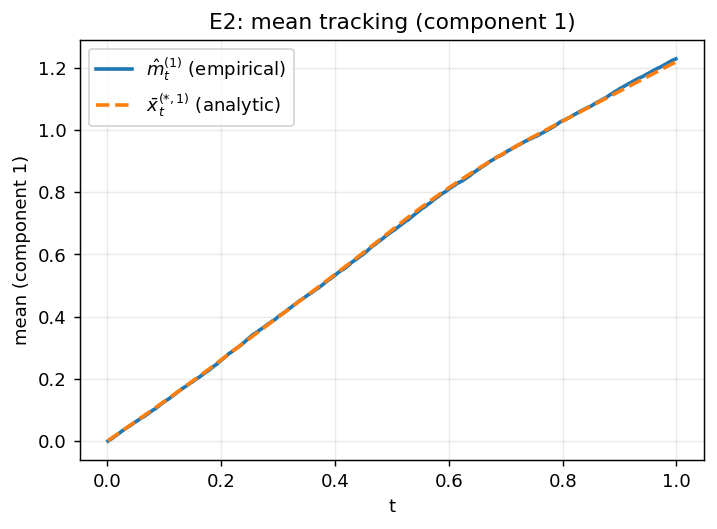

In [7]:
# -----------------------------------------------------------------------------
# Figure 1: mean component 1 vs time (empirical vs analytic)
# -----------------------------------------------------------------------------
t_cpu = tgrid.detach().cpu().numpy()
mhat_cpu = m_hat.detach().cpu().numpy()
mstar_cpu = m_star.detach().cpu().numpy()

fig1 = plt.figure(figsize=(6.2, 4.2))
plt.plot(t_cpu, mhat_cpu[:, 0], linewidth=2, label=r"$\hat m_t^{(1)}$ (empirical)")
plt.plot(t_cpu, mstar_cpu[:, 0], linewidth=2, linestyle="--", label=r"$\bar x_t^{(*,1)}$ (analytic)")
plt.xlabel("t")
plt.ylabel("mean (component 1)")
plt.title("E2: mean tracking (component 1)")
plt.legend()
plt.grid(True, alpha=0.25)

FIG_DIR = ROOT / "guided_continuous" / "test" / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
out1 = FIG_DIR / "e2_mean_component1.png"
fig1.savefig(out1, dpi=200)
print("Saved:", out1)
plt.show()


Saved: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e2_mean_component2.png


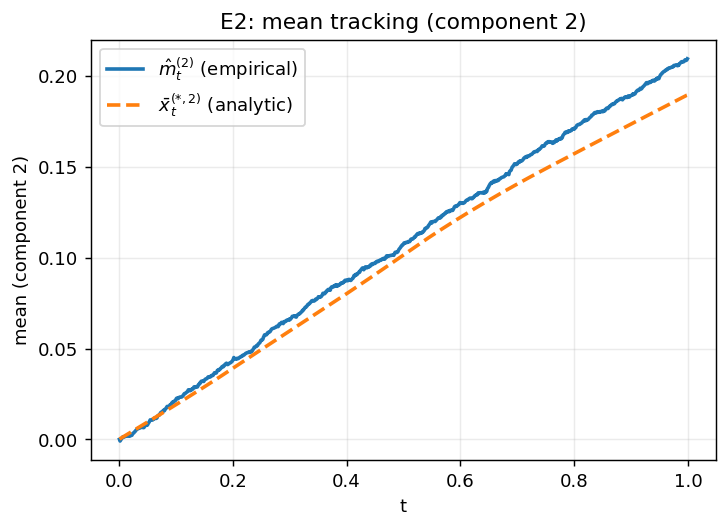

In [8]:
# -----------------------------------------------------------------------------
# Figure 2: mean component 2 vs time (empirical vs analytic)
# -----------------------------------------------------------------------------
fig2 = plt.figure(figsize=(6.2, 4.2))
plt.plot(t_cpu, mhat_cpu[:, 1], linewidth=2, label=r"$\hat m_t^{(2)}$ (empirical)")
plt.plot(t_cpu, mstar_cpu[:, 1], linewidth=2, linestyle="--", label=r"$\bar x_t^{(*,2)}$ (analytic)")
plt.xlabel("t")
plt.ylabel("mean (component 2)")
plt.title("E2: mean tracking (component 2)")
plt.legend()
plt.grid(True, alpha=0.25)

out2 = FIG_DIR / "e2_mean_component2.png"
fig2.savefig(out2, dpi=200)
print("Saved:", out2)
plt.show()


Saved: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e2_mean_error.png


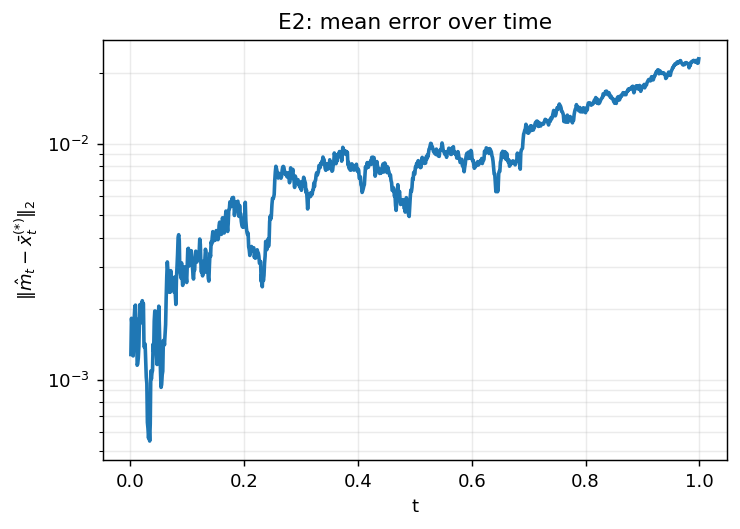

In [9]:
# -----------------------------------------------------------------------------
# Figure 3: mean error norm vs time
# -----------------------------------------------------------------------------
err_cpu = err.detach().cpu().numpy()

fig3 = plt.figure(figsize=(6.2, 4.2))
plt.plot(t_cpu, err_cpu, linewidth=2)
plt.xlabel("t")
plt.ylabel(r"$\|\hat m_t-\bar x_t^{(*)}\|_2$")
plt.title("E2: mean error over time")
plt.yscale("log")
plt.grid(True, which="both", alpha=0.25)

out3 = FIG_DIR / "e2_mean_error.png"
fig3.savefig(out3, dpi=200)
print("Saved:", out3)
plt.show()


Diagnostics on subsampled times:
  max ||MC(p*) - analytic||: 0.021020825100729824  mean: 0.006474511192073798
  max ||EM mean - analytic||: 0.02287843859415634  mean: 0.009394491511530404
Saved: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e2_three_means_comparison.png


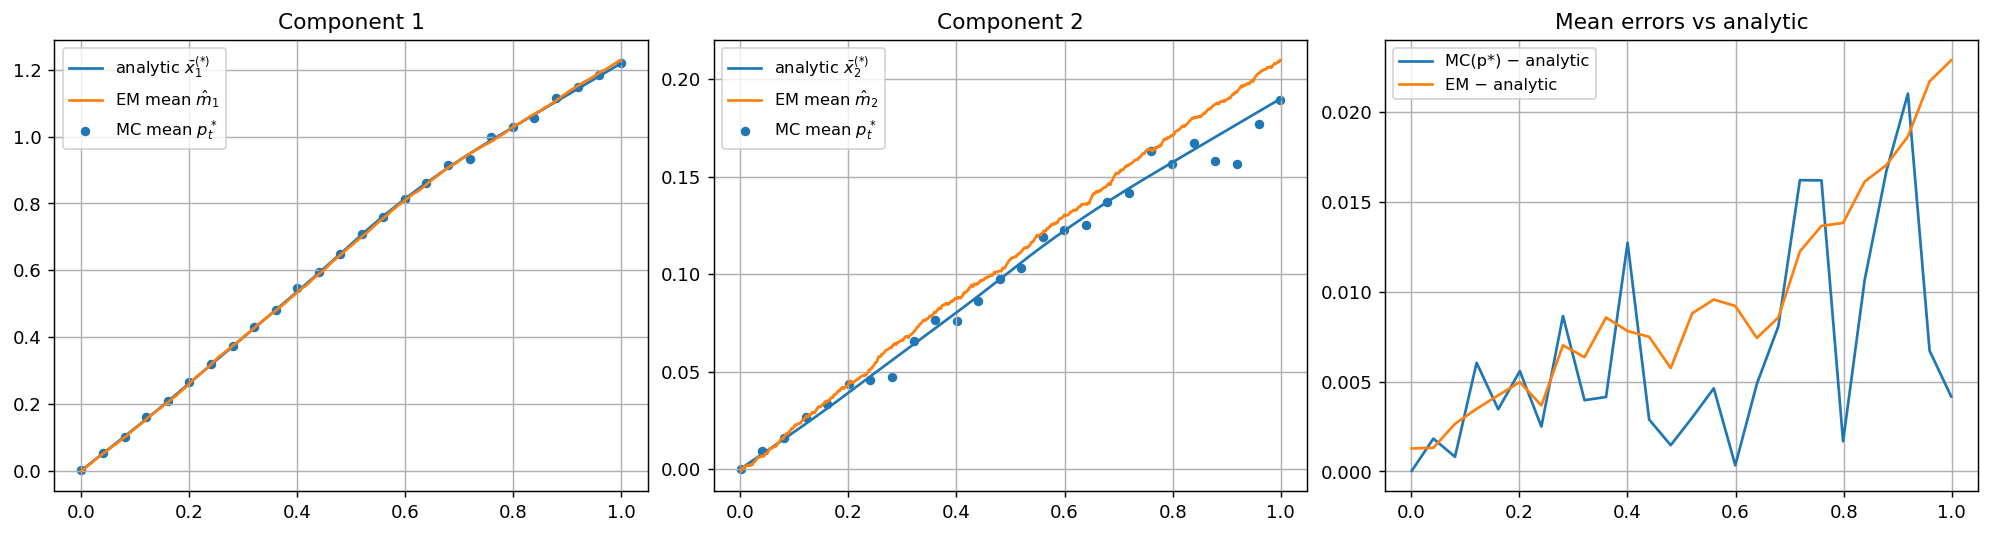

In [10]:
# -----------------------------------------------------------------------------
# E2 diagnostic: compare three means over time
#   (1) analytic  xbar_star(t)                 [Eq. (B.16)]
#   (2) MC mean   from direct samples X~p*_t   [green]
#   (3) EM mean   from simulated trajectories  [yellow]
#
# Self-contained: defines its own p*_t sampler using field._Mk_hk
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

# ---- helper: analytic mean on the EM time grid ----
def xbar_star_on_grid(field, tgrid):
    dtype  = field.coeffs.dtype
    device = field.coeffs.device
    T = int(tgrid.shape[0])
    out = torch.empty((T, 2), dtype=dtype, device=device)
    with torch.no_grad():
        for i in range(T):
            ti = tgrid[i].reshape(1)
            if hasattr(field, "time_domain") and field.time_domain is not None:
                ti = field.time_domain.clamp(ti)
            out[i] = field.xbar_star(ti).reshape(-1)
    return out  # (T,2)

# ---- helper: sample from p*_t using mixture (Mk, hk) ----
def sample_from_p_star_2d_local(field, t, n, seed=0):
    """
    Sample X ~ p*_t(x) in 2D using the Gaussian-mixture representation
    implied by Mk(t), hk(t).
    """
    dtype  = field.coeffs.dtype
    device = field.coeffs.device
    g = torch.Generator(device=device)
    g.manual_seed(int(seed))

    tt = torch.tensor([float(t)], dtype=dtype, device=device)
    if hasattr(field, "time_domain") and field.time_domain is not None:
        tt = field.time_domain.clamp(tt)

    Mk, hk, Sk, qk = field._Mk_hk(tt)   # (1,K,*,*)
    Mk, hk, Sk, qk = Mk[0], hk[0], Sk[0], qk[0]
    K = Mk.shape[0]

    # weights proportional to analytic p*_t mixture
    def logdet_spd(A):
        L = torch.linalg.cholesky(A)
        return 2.0 * torch.log(torch.diagonal(L, dim1=-2, dim2=-1)).sum(dim=-1)

    logpi = torch.log(field.target.weights.to(dtype=dtype, device=device))
    logw = (
        logpi
        - 0.5 * logdet_spd(Sk)
        - 0.5 * logdet_spd(Mk)
        + 0.5 * torch.sum(hk * torch.linalg.solve(Mk, hk.unsqueeze(-1)).squeeze(-1), dim=1)
        - 0.5 * qk
    )
    w = torch.softmax(logw, dim=0)

    # sample mixture component
    comp = torch.multinomial(w, n, replacement=True, generator=g)

    # sample from each Gaussian
    X = torch.empty((n, 2), dtype=dtype, device=device)
    eps = torch.randn((n, 2), dtype=dtype, device=device, generator=g)
    for k in range(K):
        mask = (comp == k)
        if mask.any():
            L = torch.linalg.cholesky(Mk[k])
            cov = torch.cholesky_inverse(L)
            mu = cov @ hk[k]
            X[mask] = mu + eps[mask] @ torch.linalg.cholesky(cov).T
    return X

# ---- pull data ----
tgrid = res.times
traj  = res.traj  # (T,B,2)
t_cpu = tgrid.detach().cpu()

xbar_exact = xbar_star_on_grid(field, tgrid).detach().cpu()
m_em       = traj.mean(dim=1).detach().cpu()

# ---- MC mean from p*_t at subsampled times ----
T = int(tgrid.shape[0])
stride = max(1, T // 25)
idxs = list(range(0, T, stride))
t_sub = [float(tgrid[i].item()) for i in idxs]

Ns = 12000
m_pstar = []
with torch.no_grad():
    for j, tj in enumerate(t_sub):
        z = sample_from_p_star_2d_local(field, tj, Ns, seed=80_000 + j)
        m_pstar.append(z.mean(dim=0).detach().cpu())
m_pstar = torch.stack(m_pstar, dim=0)

# ---- diagnostics ----
err_green  = torch.norm(m_pstar - xbar_exact[idxs], dim=1)
err_yellow = torch.norm(m_em[idxs] - xbar_exact[idxs], dim=1)

print("Diagnostics on subsampled times:")
print("  max ||MC(p*) - analytic||:", float(err_green.max()), " mean:", float(err_green.mean()))
print("  max ||EM mean - analytic||:", float(err_yellow.max()), " mean:", float(err_yellow.mean()))

# ---- plots ----
fig, axes = plt.subplots(1, 3, figsize=(15.2, 4.0), constrained_layout=True)

axes[0].plot(t_cpu, xbar_exact[:, 0], label="analytic $\\bar x^{(*)}_1$")
axes[0].plot(t_cpu, m_em[:, 0], label="EM mean $\\hat m_1$")
axes[0].scatter([t_cpu[i] for i in idxs], m_pstar[:, 0], s=18, label="MC mean $p^*_t$")
axes[0].set_title("Component 1"); axes[0].grid(True); axes[0].legend(fontsize=9)

axes[1].plot(t_cpu, xbar_exact[:, 1], label="analytic $\\bar x^{(*)}_2$")
axes[1].plot(t_cpu, m_em[:, 1], label="EM mean $\\hat m_2$")
axes[1].scatter([t_cpu[i] for i in idxs], m_pstar[:, 1], s=18, label="MC mean $p^*_t$")
axes[1].set_title("Component 2"); axes[1].grid(True); axes[1].legend(fontsize=9)

axes[2].plot([t_cpu[i] for i in idxs], err_green, label="MC(p*) − analytic")
axes[2].plot([t_cpu[i] for i in idxs], err_yellow, label="EM − analytic")
axes[2].set_title("Mean errors vs analytic")
axes[2].grid(True); axes[2].legend(fontsize=9)

FIG_DIR = ROOT / "guided_continuous" / "test" / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "e2_three_means_comparison.png"
fig.savefig(out_path, dpi=200)
print("Saved:", out_path)

plt.show()


p*_sampling vs exact mean:
  max ||Δ||_2: 0.04218389710375446
  mean||Δ||_2: 0.009285423667217152
Saved: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e2_pstar_sampling_vs_exact_mean.png


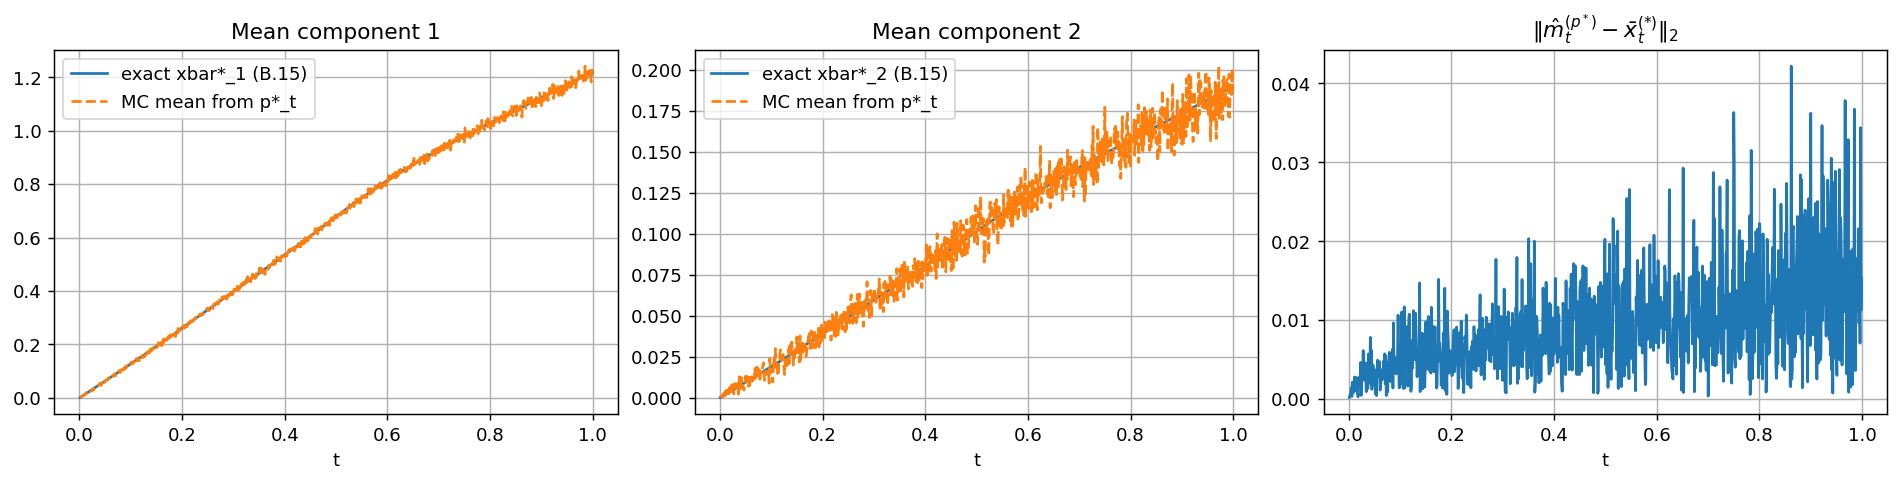

In [11]:
# -----------------------------------------------------------------------------
# E2 add-on: validate analytic mean xbar*_t (Eq. B.15) via sampling from p*_t(x)
# (compatible with GuidedField.xbar_star scalar-only API)
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

def _p_star_mixture_params_2d(field, t):
    """
    Build the implied GM representation of p*_t(x) in 2D:
      p*_t(x) = sum_k w_k(t)  N(x; mu_k(t), C_k(t)),
    where C_k(t) = M_k(t)^{-1}, mu_k(t) = M_k(t)^{-1} h_k(t),
    and w_k(t) are the normalized weights derived from Eq. (B.12)/(B.15).
    """
    dtype  = field.coeffs.dtype
    device = field.coeffs.device

    t = torch.as_tensor(t, dtype=dtype, device=device).reshape(1)
    t = field.time_domain.clamp(t)

    gm = field.target
    K = int(gm.weights.shape[0])
    d = int(gm.means.shape[1])
    assert d == 2, "This helper is specialized for d=2."

    I = torch.eye(d, dtype=dtype, device=device)

    # Continuous coeffs at time t
    a_p   = field.coeffs.a_plus(t)[0]
    a_m   = field.coeffs.a_minus(t)[0]
    b_m   = field.coeffs.b_minus(t)[0]
    c_m   = field.coeffs.c_minus(t)[0]
    th_p  = field.coeffs.theta_plus(t)[0]
    th_xm = field.coeffs.theta_x_minus(t)[0]
    th_ym = field.coeffs.theta_y_minus(t)[0]

    # Cached endpoint constants (no call at t=1)
    a1p  = field.coeffs.a_plus_1
    th1p = field.coeffs.theta_plus_1

    Kt = c_m - a1p
    Kt = torch.clamp(Kt, min=torch.as_tensor(1e-12, dtype=dtype, device=device))

    alpha = b_m / Kt
    dbar  = (th_ym - th1p) / Kt

    logw_list = []
    mu_list = []
    C_list  = []

    for k in range(K):
        Sig = gm.covs[k].to(dtype=dtype, device=device)
        mk  = gm.means[k].to(dtype=dtype, device=device)

        # S_k(t)
        S = Sig + (1.0 / Kt) * I
        S = 0.5 * (S + S.T)
        Sinv = torch.linalg.inv(S)

        # M_k(t)
        M = (a_p + a_m - (b_m*b_m)/Kt) * I + (alpha*alpha) * Sinv
        M = 0.5 * (M + M.T)

        # h_k(t)
        h = th_p + th_xm + b_m * dbar + alpha * (Sinv @ (mk - dbar))

        # Component Gaussian params
        Ck = torch.linalg.inv(M)
        muk = Ck @ h

        # log unnormalized weights (time-only)
        signS, logdetS = torch.linalg.slogdet(S)
        signM, logdetM = torch.linalg.slogdet(M)
        if (signS <= 0) or (signM <= 0):
            raise RuntimeError("Non-PD S_k or M_k encountered while building p*_t mixture.")

        quad_h = 0.5 * (h @ (Ck @ h))
        quad_m = 0.5 * ((mk - dbar) @ (Sinv @ (mk - dbar)))

        logwk = torch.log(gm.weights[k].to(dtype=dtype, device=device)) - 0.5*logdetS - 0.5*logdetM + quad_h - quad_m

        logw_list.append(logwk)
        mu_list.append(muk)
        C_list.append(Ck)

    logw = torch.stack(logw_list, dim=0)  # (K,)
    w = torch.softmax(logw, dim=0)        # normalized weights
    mu = torch.stack(mu_list, dim=0)      # (K,2)
    C  = torch.stack(C_list,  dim=0)      # (K,2,2)
    return w, mu, C


def sample_from_p_star_2d(field, t, n, seed=0):
    """
    Sample n points from p*_t(x) in 2D using the implied GM representation.
    """
    dtype  = field.coeffs.dtype
    device = field.coeffs.device

    w, mu, C = _p_star_mixture_params_2d(field, t)
    K = int(w.shape[0])

    g = torch.Generator(device=device)
    g.manual_seed(int(seed))

    k = torch.multinomial(w, num_samples=int(n), replacement=True, generator=g)  # (n,)
    eps = torch.randn((int(n), 2), dtype=dtype, device=device, generator=g)
    out = torch.empty((int(n), 2), dtype=dtype, device=device)

    for kk in range(K):
        mask = (k == kk)
        if mask.any():
            L = torch.linalg.cholesky(C[kk])
            out[mask] = mu[kk] + eps[mask] @ L.T
    return out


# --- Compare xbar*_t (analytic) vs MC mean from p*_t sampling ---
tgrid = res.times  # (T,)
T = int(tgrid.shape[0])

# analytic mean from Eq. (B.15) via scalar calls
dtype  = field.coeffs.dtype
device = field.coeffs.device
xbar_exact = torch.empty((T, 2), dtype=dtype, device=device)

with torch.no_grad():
    for i in range(T):
        ti = tgrid[i].reshape(1)  # (1,)
        xbar_exact[i] = field.xbar_star(ti).reshape(-1)  # (2,)

# MC estimate by sampling p*_t at each time
Ns = 6000
xbar_pmc = torch.empty((T, 2), dtype=dtype, device=device)

with torch.no_grad():
    for i in range(T):
        ti = float(tgrid[i].item())
        z = sample_from_p_star_2d(field, ti, Ns, seed=1000 + i)
        xbar_pmc[i] = z.mean(dim=0)

# errors
err = (xbar_pmc - xbar_exact).norm(dim=1).detach().cpu()
t_cpu = tgrid.detach().cpu()
xbar_exact_cpu = xbar_exact.detach().cpu()
xbar_pmc_cpu = xbar_pmc.detach().cpu()

print("p*_sampling vs exact mean:")
print("  max ||Δ||_2:", float(err.max()))
print("  mean||Δ||_2:", float(err.mean()))

# --- Plot: component-wise curves + error ---
fig, axes = plt.subplots(1, 3, figsize=(14.5, 3.6), constrained_layout=True)

axes[0].plot(t_cpu, xbar_exact_cpu[:, 0], label="exact xbar*_1 (B.15)")
axes[0].plot(t_cpu, xbar_pmc_cpu[:, 0],  "--", label="MC mean from p*_t")
axes[0].set_title("Mean component 1")
axes[0].set_xlabel("t"); axes[0].grid(True); axes[0].legend()

axes[1].plot(t_cpu, xbar_exact_cpu[:, 1], label="exact xbar*_2 (B.15)")
axes[1].plot(t_cpu, xbar_pmc_cpu[:, 1],  "--", label="MC mean from p*_t")
axes[1].set_title("Mean component 2")
axes[1].set_xlabel("t"); axes[1].grid(True); axes[1].legend()

axes[2].plot(t_cpu, err)
axes[2].set_title(r"$\|\hat m_t^{(p^*)} - \bar x_t^{(*)}\|_2$")
axes[2].set_xlabel("t"); axes[2].grid(True)

# save
FIG_DIR = ROOT / "guided_continuous" / "test" / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "e2_pstar_sampling_vs_exact_mean.png"
fig.savefig(out_path, dpi=200)
print("Saved:", out_path)

plt.show()


In [12]:
# -----------------------------------------------------------------------------
# Debug cell: alternative u*(t,x) from Eq. (B.16) and compare with field.u_star
# -----------------------------------------------------------------------------
import torch

def _broadcast_time_for_x(field, t, x):
    """
    Create a batched time tensor tt compatible with x (batch size B).
    We avoid guessing internal helper names; we only use time_domain.clamp if present.
    """
    B = x.shape[0]
    dtype = x.dtype
    device = x.device

    tt = torch.as_tensor(t, dtype=dtype, device=device)
    if tt.ndim == 0:
        tt = tt.reshape(1)
    if tt.numel() == 1:
        tt = tt.repeat(B)

    # If TimeDomain is wired, clamp to interior (important near ends)
    if hasattr(field, "time_domain") and field.time_domain is not None:
        tt = field.time_domain.clamp(tt)

    return tt  # (B,)

def _as_bd(theta_or_a, B, d):
    """
    Convert coefficient output to shape (B,d) for broadcasting with x.
    Handles:
      - scalar () or (1,) or (B,) -> (B,1) then broadcast to (B,d) only if d==1;
      - (d,) -> expand to (B,d);
      - (B,d) -> keep.
    """
    t = theta_or_a
    if not torch.is_tensor(t):
        t = torch.as_tensor(t)

    if t.ndim == 0:
        # scalar
        t = t.reshape(1)

    if t.ndim == 1:
        if t.numel() == d:
            # (d,)
            return t.reshape(1, d).expand(B, d)
        if t.numel() == B:
            # (B,) -> interpret as per-batch scalar; expand to (B,d) only if d==1
            if d != 1:
                # treat as (B,1) then broadcast via multiplication with x (works for a),
                # but for theta we want explicit (B,d) and can't invent direction.
                return t.reshape(B, 1).expand(B, d)
            return t.reshape(B, 1)
        if t.numel() == 1:
            return t.reshape(1, 1).expand(B, d)
        raise ValueError(f"Cannot coerce 1D tensor of shape {tuple(t.shape)} to (B,d) with B={B}, d={d}")

    if t.ndim == 2:
        if t.shape == (B, d):
            return t
        if t.shape == (B, 1):
            return t.expand(B, d)
        if t.shape == (1, d):
            return t.expand(B, d)
        raise ValueError(f"Cannot coerce 2D tensor of shape {tuple(t.shape)} to (B,d) with B={B}, d={d}")

    raise ValueError(f"Unsupported tensor rank {t.ndim} for broadcasting to (B,d).")

def u_star_new(field, t, x):
    """
    Alternative u*(t,x) (Eq. (B.15)):
      u* = a_plus(t) x - theta_plus(t) + sum_k w_k(t,x) (h_k(t) - M_k(t) x)
    We compute the mixture-gradient term as grad_x log p*_t(x), using field.log_p_star.
    """
    if x.ndim != 2:
        raise ValueError("x must have shape (B,d).")
    B, d = x.shape

    tt = _broadcast_time_for_x(field, t, x)  # (B,)

    # --- compute grad_x log p*_t(x) via autograd (robust; no assumptions on internal S/M/h) ---
    x_req = x.detach().clone().requires_grad_(True)
    with torch.enable_grad():
        logp = field.log_p_star(tt, x_req)  # expected (B,) or (B,1)
        if logp.ndim == 2 and logp.shape[1] == 1:
            logp = logp.squeeze(1)
        if logp.ndim != 1 or logp.shape[0] != B:
            raise ValueError(f"field.log_p_star(t,x) must return (B,) (or (B,1)); got {tuple(logp.shape)}")

        grad_logp = torch.autograd.grad(logp.sum(), x_req, create_graph=False)[0]  # (B,d)

    # --- affine term: a_plus(t) x - theta_plus(t) ---
    # We avoid guessing: use coeffs attributes already used elsewhere (b_minus etc.).
    a = field.coeffs.a_plus(tt)        # expect scalar-per-batch or scalar
    th = field.coeffs.theta_plus(tt)   # expect (B,d) or (d,) or broadcastable

    a_bd  = _as_bd(a,  B, d)     # (B,d) (interpreting scalar as same in all dims)
    th_bd = _as_bd(th, B, d)     # (B,d)

    return a_bd * x + (-th_bd) + grad_logp  # (B,d)

# -----------------------------------------------------------------------------
# Compare u_star_new vs field.u_star on representative points
# -----------------------------------------------------------------------------
def compare_u_star(field, t_list, N=8000, seed=0, source="pstar"):
    """
    Compare at times in t_list.
    source:
      - "pstar": sample X from p*_t using sample_from_p_star_2d (must exist in notebook)
      - "randn": sample X ~ N(0,I)
    """
    torch.manual_seed(int(seed))

    dtype  = field.coeffs.dtype
    device = field.coeffs.device

    rows = []
    for j, t0 in enumerate(t_list):
        t0 = float(t0)

        if source == "pstar":
            # requires that you already have sample_from_p_star_2d(field, t, n, seed) in notebook
            X = sample_from_p_star_2d(field, t0, int(N), seed=seed + 17*j).to(dtype=dtype, device=device)
        elif source == "randn":
            X = torch.randn((int(N), 2), dtype=dtype, device=device)
        else:
            raise ValueError("source must be 'pstar' or 'randn'.")

        tt = torch.full((int(N),), t0, dtype=dtype, device=device)
        if hasattr(field, "time_domain") and field.time_domain is not None:
            tt = field.time_domain.clamp(tt)

        with torch.no_grad():
            u_old = field.u_star(tt, X)           # (N,2)
            u_new = u_star_new(field, tt, X)      # (N,2)
            du = (u_new - u_old).norm(dim=1)

        rows.append((
            t0,
            float(du.mean().cpu()),
            float(du.max().cpu()),
            float(u_old.norm(dim=1).mean().cpu()),
            float(u_new.norm(dim=1).mean().cpu()),
        ))

    # pretty print
    print("Compare u_star_new (Eq B.16) vs field.u_star")
    print("t        | mean||Δu||     max||Δu||      mean||u_old||   mean||u_new||")
    print("-----------------------------------------------------------------------")
    for r in rows:
        print(f"{r[0]:.6f} | {r[1]:.3e}   {r[2]:.3e}    {r[3]:.3e}     {r[4]:.3e}")

# Choose interior times (respect TimeDomain); reuse your E2 grid endpoints if you like.
tgrid = res.times
t_list = [
    float(tgrid[0].cpu()),                                  # near eps
    float(tgrid[int(0.25*(len(tgrid)-1))].cpu()),
    float(tgrid[int(0.50*(len(tgrid)-1))].cpu()),
    float(tgrid[int(0.75*(len(tgrid)-1))].cpu()),
    float(tgrid[-1].cpu()),                                 # near 1-eps
]

compare_u_star(field, t_list, N=6000, seed=3, source="pstar")


Compare u_star_new (Eq B.16) vs field.u_star
t        | mean||Δu||     max||Δu||      mean||u_old||   mean||u_new||
-----------------------------------------------------------------------
0.001000 | 1.880e-14   1.766e-13    1.279e+00     1.279e+00
0.250831 | 9.118e-16   8.992e-15    1.513e+00     1.513e+00
0.500000 | 1.735e-15   1.223e-14    1.548e+00     1.548e+00
0.749004 | 1.565e-15   1.047e-14    1.231e+00     1.231e+00
0.999000 | 3.310e-13   2.903e-12    2.467e+00     2.467e+00


Common-noise mean difference:
  max ||m_new - m_old||_2: 5.095246377785861e-16  mean: 1.3167283958291433e-16
Target mean: (1.22, 0.18999999999999997)
Saved: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks/guided_continuous/test/figs/e2_compare_old_vs_new_u_star_means_with_target.png


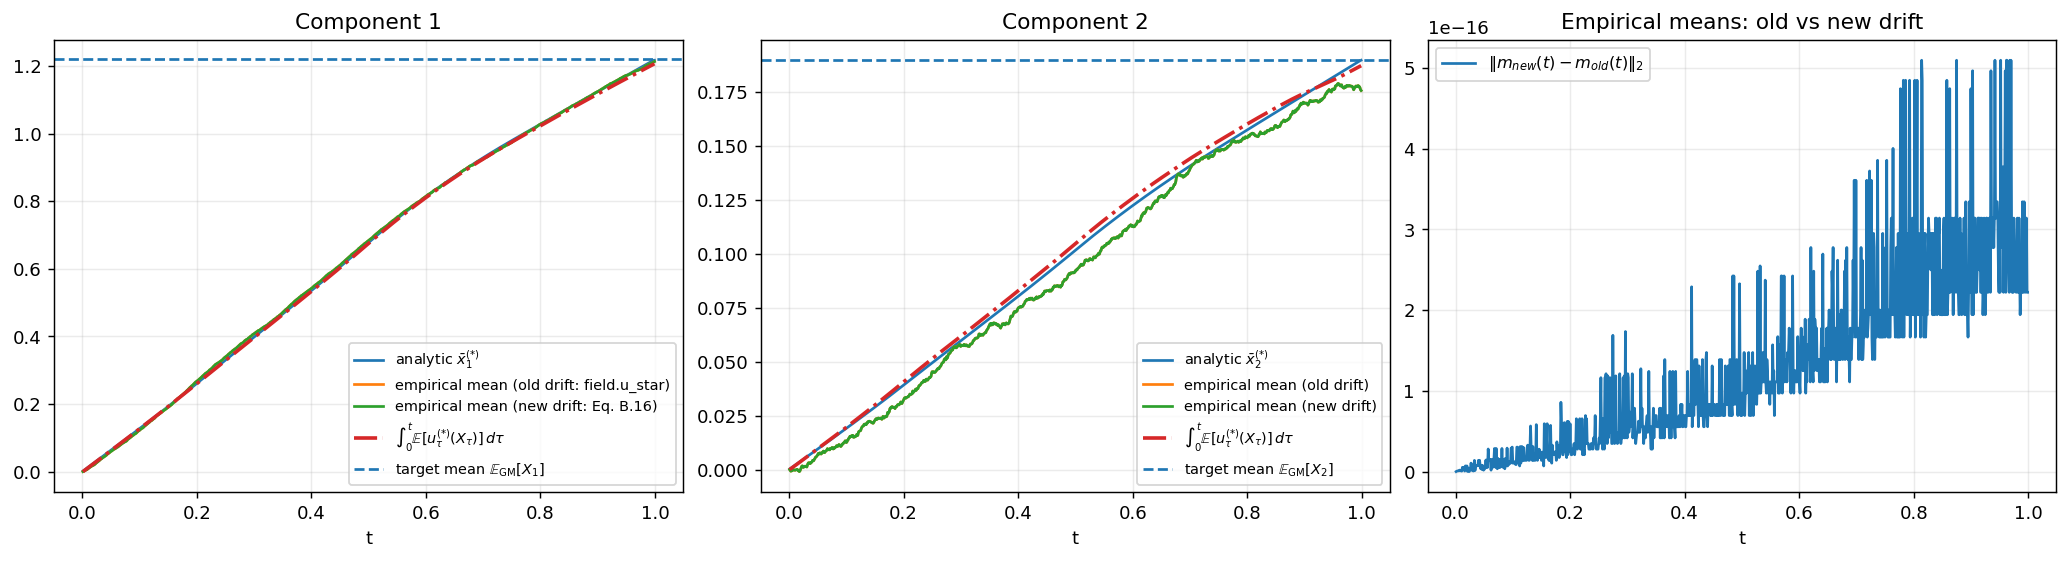

In [13]:
# -----------------------------------------------------------------------------
# Simulate SDE with BOTH drift constructions (field.u_star vs u_star_new)
# using COMMON random numbers, compare empirical means to analytic xbar_star,
# and add target mean as horizontal dashed lines in component plots.
# ALSO add the mean reconstructed as  ∫_0^t E[u*_\tau(X_\tau)] dτ  (from EM samples).
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

def xbar_star_on_grid_scalar_api(field, times):
    """Evaluate field.xbar_star on a 1D time grid using scalar-only API."""
    dtype  = field.coeffs.dtype
    device = field.coeffs.device
    T = int(times.shape[0])
    out = torch.empty((T, 2), dtype=dtype, device=device)
    with torch.no_grad():
        for i in range(T):
            ti = times[i].reshape(1).to(dtype=dtype, device=device)
            if hasattr(field, "time_domain") and field.time_domain is not None:
                ti = field.time_domain.clamp(ti)
            out[i] = field.xbar_star(ti).reshape(-1)
    return out  # (T,2)

def simulate_common_noise_two_drifts(field, times, *, B, d, seed=0):
    """
    Simulate two trajectories with the same Brownian increments:
      X^{old}: drift = field.u_star
      X^{new}: drift = u_star_new(field, ...)
    Noise term is dW with unit diffusion.
    """
    dtype  = field.coeffs.dtype
    device = field.coeffs.device
    gen = torch.Generator(device=device)
    gen.manual_seed(int(seed))

    T = int(times.shape[0])
    times = times.to(dtype=dtype, device=device)

    x_old = torch.zeros((B, d), dtype=dtype, device=device)
    x_new = torch.zeros((B, d), dtype=dtype, device=device)

    traj_old = torch.empty((T, B, d), dtype=dtype, device=device)
    traj_new = torch.empty((T, B, d), dtype=dtype, device=device)
    traj_old[0] = x_old
    traj_new[0] = x_new

    for i in range(T - 1):
        t = times[i]
        dt = float(times[i+1] - times[i])

        # clamp only for drift evaluation
        t_eval = t
        if hasattr(field, "time_domain") and field.time_domain is not None:
            t_eval = field.time_domain.clamp(t_eval.reshape(1)).reshape(())

        dW = torch.sqrt(torch.tensor(dt, dtype=dtype, device=device)) * torch.randn(
            (B, d), dtype=dtype, device=device, generator=gen
        )

        drift_old = field.u_star(t_eval, x_old)
        x_old = x_old + drift_old * dt + dW

        drift_new = u_star_new(field, t_eval, x_new)
        x_new = x_new + drift_new * dt + dW

        traj_old[i+1] = x_old
        traj_new[i+1] = x_new

    return traj_old, traj_new

# -----------------------------------------------------------------------------
# Run
# -----------------------------------------------------------------------------
times = res.times
B = 6000
d = 2
seed = 7

traj_old, traj_new = simulate_common_noise_two_drifts(field, times, B=B, d=d, seed=seed)

m_old = traj_old.mean(dim=1).detach().cpu()   # (T,2)
m_new = traj_new.mean(dim=1).detach().cpu()   # (T,2)
t_cpu = times.detach().cpu()

xbar = xbar_star_on_grid_scalar_api(field, times).detach().cpu()  # (T,2)

# -----------------------------------------------------------------------------
# NEW: mean via integrated expected drift along EM samples:
#   m_int(t_k) ≈ sum_{j<k} E[u*(t_j, X_{t_j})] Δt
# using traj_old (old drift = field.u_star) and the SAME time grid.
# -----------------------------------------------------------------------------
with torch.no_grad():
    T = int(times.shape[0])
    dt_vec = (times[1:] - times[:-1]).to(dtype=field.coeffs.dtype, device=field.coeffs.device)  # (T-1,)

    Eu = torch.empty((T-1, d), dtype=field.coeffs.dtype, device=field.coeffs.device)  # (T-1,2)

    for i in range(T - 1):
        ti = times[i]
        ti_eval = ti
        if hasattr(field, "time_domain") and field.time_domain is not None:
            ti_eval = field.time_domain.clamp(ti_eval.reshape(1)).reshape(())

        ui = field.u_star(ti_eval, traj_old[i])  # (B,2)
        Eu[i] = ui.mean(dim=0)                   # (2,)

    m_int = torch.zeros((T, d), dtype=field.coeffs.dtype, device=field.coeffs.device)
    m_int[1:] = torch.cumsum(Eu * dt_vec.unsqueeze(1), dim=0)
    m_int = m_int.detach().cpu()

# -----------------------------------------------------------------------------
# Target mean (Gaussian mixture mean)  [MUST be defined before printing/plotting]
# -----------------------------------------------------------------------------
with torch.no_grad():
    w  = field.target.weights.detach().cpu()
    mu = field.target.means.detach().cpu()
    m_target = (w.reshape(-1, 1) * mu).sum(dim=0)  # (2,)

# sanity: how close are the two empirical means?
dm = torch.norm(m_new - m_old, dim=1)
print("Common-noise mean difference:")
print("  max ||m_new - m_old||_2:", float(dm.max()), " mean:", float(dm.mean()))
print("Target mean:", tuple(float(v) for v in m_target))

# -----------------------------------------------------------------------------
# Plot (two components + mean differences)
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15.8, 4.2), constrained_layout=True)

# component 1
axes[0].plot(t_cpu, xbar[:,0], label="analytic $\\bar x^{(*)}_1$")
axes[0].plot(t_cpu, m_old[:,0], label="empirical mean (old drift: field.u_star)")
axes[0].plot(t_cpu, m_new[:,0], label="empirical mean (new drift: Eq. B.16)")
axes[0].plot(
    t_cpu, m_int[:,0],
    linestyle="-.", linewidth=2.0,
    label=r"$\int_0^t \mathbb{E}[u^{(*)}_\tau(X_\tau)]\,d\tau$"
)
axes[0].axhline(float(m_target[0]), linestyle="--", linewidth=1.5, label="target mean $\\mathbb{E}_{\\text{GM}}[X_1]$")
axes[0].set_title("Component 1")
axes[0].set_xlabel("t")
axes[0].grid(True, alpha=0.25)
axes[0].legend(fontsize=8)

# component 2
axes[1].plot(t_cpu, xbar[:,1], label="analytic $\\bar x^{(*)}_2$")
axes[1].plot(t_cpu, m_old[:,1], label="empirical mean (old drift)")
axes[1].plot(t_cpu, m_new[:,1], label="empirical mean (new drift)")
axes[1].plot(
    t_cpu, m_int[:,1],
    linestyle="-.", linewidth=2.0,
    label=r"$\int_0^t \mathbb{E}[u^{(*)}_\tau(X_\tau)]\,d\tau$"
)
axes[1].axhline(float(m_target[1]), linestyle="--", linewidth=1.5, label="target mean $\\mathbb{E}_{\\text{GM}}[X_2]$")
axes[1].set_title("Component 2")
axes[1].set_xlabel("t")
axes[1].grid(True, alpha=0.25)
axes[1].legend(fontsize=8)

# difference between the two empirical means
axes[2].plot(t_cpu, dm, label="$\\|m_{new}(t)-m_{old}(t)\\|_2$")
axes[2].set_title("Empirical means: old vs new drift")
axes[2].set_xlabel("t")
axes[2].grid(True, alpha=0.25)
axes[2].legend(fontsize=9)

# save
FIG_DIR = ROOT / "guided_continuous" / "test" / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
out_path = FIG_DIR / "e2_compare_old_vs_new_u_star_means_with_target.png"
fig.savefig(out_path, dpi=200)
print("Saved:", out_path)

plt.show()


In [14]:
# -----------------------------------------------------------------------------
# Mode proportions at terminal time under TRUE target GM responsibilities
# -----------------------------------------------------------------------------
xT = traj[-1].detach()  # (B,2)

with torch.no_grad():
    w  = field.target.weights
    mu = field.target.means
    Sig= field.target.covs
    Kmix = int(w.numel())
    d = xT.shape[1]
    log2pi = torch.log(torch.tensor(2.0 * torch.pi, dtype=xT.dtype, device=xT.device))

    logp = []
    for k in range(Kmix):
        L = torch.linalg.cholesky(Sig[k])
        diff = xT - mu[k]
        sol  = torch.cholesky_solve(diff.unsqueeze(-1), L).squeeze(-1)
        quad = (diff * sol).sum(dim=1)
        logdet = 2.0 * torch.log(torch.diagonal(L)).sum()
        logNk = -0.5 * (quad + logdet + d * log2pi)
        logp.append(torch.log(w[k]) + logNk)
    logp = torch.stack(logp, dim=1)  # (B,K)
    resp = torch.softmax(logp, dim=1) # (B,K)
    frac = resp.mean(dim=0)          # (K,)

print("Target weights:", w.detach().cpu().numpy())
print("Empirical terminal responsibilities:", frac.detach().cpu().numpy())
print("Difference:", (frac - w).detach().cpu().numpy())


Target weights: [0.45 0.35 0.2 ]
Empirical terminal responsibilities: [0.45818067 0.34700596 0.19481337]
Difference: [ 0.00818067 -0.00299404 -0.00518663]


X-grid: torch.Size([1681, 2]) x_lim= 6.0

KFP p-form residual with fitted λ(t) (f=0, mask_drop=25, p_mode='exp_logp'):
{'t': 0.01, 'keep_frac': 0.01249256357550621, 'lambda_hat': 200.03333243221664, 'RMS_R': 43.661472761437324, 'RMS_R_center': 1.3311012902930454e-14, 'Max|R|': 200.0333324322167, 'Max|R_center|': 5.684341886080802e-14, 'power_explained_by_lambda_p': 1.0, 'p_mode': 'exp_logp'}
{'t': 0.1, 'keep_frac': 0.08804283291101456, 'lambda_hat': 20.33222748897045, 'RMS_R': 3.1723279582224695, 'RMS_R_center': 4.339348930207725e-15, 'Max|R|': 20.33222748897045, 'Max|R_center|': 2.7533531010703882e-14, 'power_explained_by_lambda_p': 1.0, 'p_mode': 'exp_logp'}
{'t': 0.2, 'keep_frac': 0.1505056470632553, 'lambda_hat': 10.65794377124625, 'RMS_R': 1.5546603067645615, 'RMS_R_center': 9.139314973364963e-16, 'Max|R|': 10.657943771246252, 'Max|R_center|': 5.329070518200751e-15, 'power_explained_by_lambda_p': 1.0, 'p_mode': 'exp_logp'}
{'t': 0.3, 'keep_frac': 0.20464009046554565, 'lambda_hat':

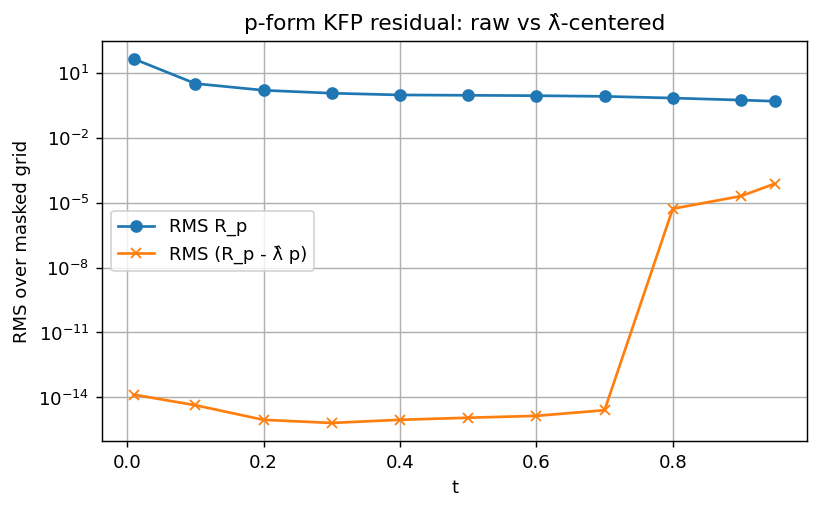

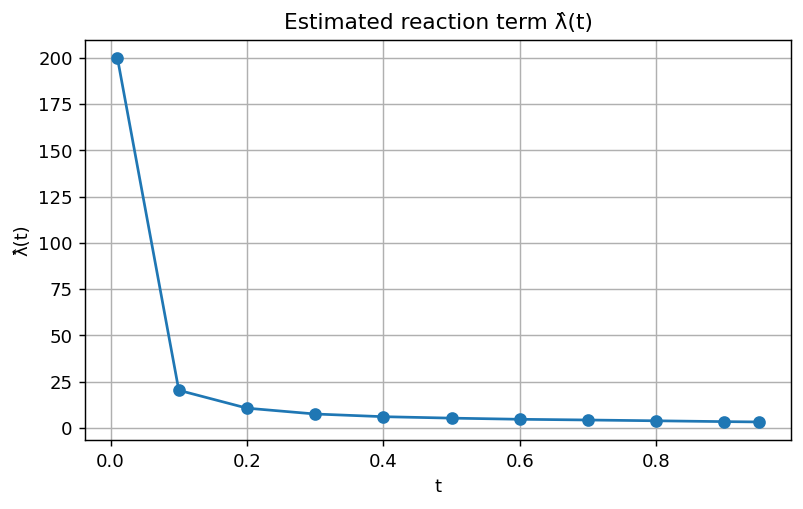

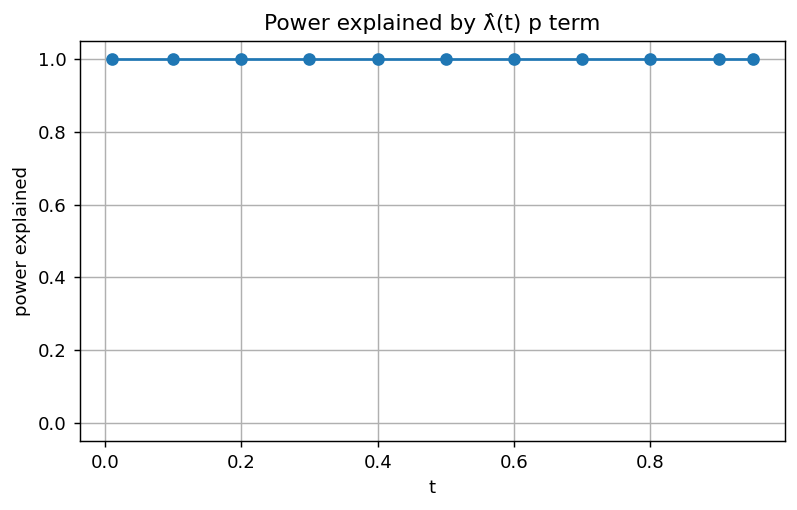

In [15]:
# -----------------------------------------------------------------------------
# KFP "reaction term" test in p-form (f = 0): estimate λ(t) in
#
#   ∂t p + ∇·(p u) = (1/2) Δ p + λ(t) p
#
# This is the correct notion of "KFP holds up to a time-dependent factor" when
# p is only known up to multiplication by c(t). In log-form this corresponds to
# adding a constant offset to r(t,x).
#
# We compute the residual in p-form:
#   R_p(t,x) := ∂t p + ∇·(p u) - (1/2) Δ p
# then estimate the best λ(t) (least squares on masked region):
#   λ_hat(t) = <R_p, p> / <p, p>
# and report the centered residual:
#   R_center = R_p - λ_hat p
#
# If the "up-to-factor" explanation is correct, RMS(R_center) << RMS(R_p).
#
# Plots: RMS(R_p) vs RMS(R_center) and λ_hat(t) vs t.
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

dtype  = torch.float64
device = device

def kfp_reaction_fit_on_grid(field, t_scalar, X, mask_drop=25.0, p_mode="exp_logp"):
    """
    Computes p-form KFP residual and fits λ(t) on a fixed x-grid.

    p_mode:
      "p_star"   : uses field.p_star(t_vec, x) if available
      "exp_logp" : uses exp(field.log_p_star(t_vec, x)) (default)

    Returns stats dict.
    """
    B, d = X.shape
    t_vec = torch.full((B,), float(t_scalar), dtype=dtype, device=device, requires_grad=True)
    x = X.detach().clone().to(dtype=dtype, device=device).requires_grad_(True)

    # logp for masking (always available in your API)
    logp = field.log_p_star(t_vec, x)
    if logp.ndim == 2 and logp.shape[1] == 1:
        logp = logp[:, 0]

    lpmax = logp.detach().max()
    keep = (logp.detach() >= (lpmax - mask_drop)) & torch.isfinite(logp.detach())
    if keep.sum() < 20:
        return {"t": t_scalar, "note": "mask too strict / too few points", "keep_frac": float(keep.float().mean().cpu())}

    # choose p
    if p_mode == "p_star":
        assert hasattr(field, "p_star"), "p_mode='p_star' requested but field has no p_star"
        p = field.p_star(t_vec, x)
        if p.ndim == 2 and p.shape[1] == 1:
            p = p[:, 0]
    elif p_mode == "exp_logp":
        # stable exp: shift by max on the full grid (does not change PDE up to factor)
        # NOTE: scaling p by a time-dependent constant does not affect the existence of λ(t).
        p = torch.exp(logp - logp.detach().max())
    else:
        raise ValueError("p_mode must be 'p_star' or 'exp_logp'")

    # ---- ∂t p (pointwise) ----
    dp_dt = torch.autograd.grad(
        outputs=p,
        inputs=t_vec,
        grad_outputs=torch.ones_like(p),
        create_graph=True,
        retain_graph=True
    )[0]  # (B,)

    # ---- spatial derivatives for divergence and Laplacian ----
    # u*(t,x)
    u = field.u_star(t_vec, x)  # (B,d)

    # divergence of (p u): ∇·(p u) = sum_i ∂_{x_i} (p u_i)
    # do it dimension by dimension
    div_pu = torch.zeros((B,), dtype=dtype, device=device)
    for i in range(d):
        pu_i = p * u[:, i]
        grad_pu_i = torch.autograd.grad(pu_i.sum(), x, create_graph=True, retain_graph=True)[0]  # (B,d)
        div_pu = div_pu + grad_pu_i[:, i]

    # Laplacian of p: Δ p
    grad_p = torch.autograd.grad(p.sum(), x, create_graph=True, retain_graph=True)[0]  # (B,d)
    lap_p = torch.zeros((B,), dtype=dtype, device=device)
    for i in range(d):
        gi = grad_p[:, i]
        Hgi = torch.autograd.grad(gi.sum(), x, create_graph=True, retain_graph=True)[0]
        lap_p = lap_p + Hgi[:, i]

    # p-form residual
    R = dp_dt + div_pu - 0.5 * lap_p  # (B,)

    # mask + finiteness
    good = keep & torch.isfinite(R) & torch.isfinite(p) & (p.detach() > 0)
    if good.sum() < 20:
        return {"t": t_scalar, "note": "non-finite after masking", "keep_frac": float(keep.float().mean().cpu())}

    Rg = R[good].detach()
    pg = p[good].detach()

    # least squares λ_hat = <R, p> / <p, p>
    lam = (Rg @ pg) / (pg @ pg)

    Rc = Rg - lam * pg

    # stats
    def rms(z): return torch.sqrt(torch.mean(z*z)).item()
    def mx(z):  return torch.max(torch.abs(z)).item()

    rms_R  = rms(Rg)
    rms_Rc = rms(Rc)
    mx_R   = mx(Rg)
    mx_Rc  = mx(Rc)

    # "power explained" by λ(t) p
    power_expl = 1.0 - (rms_Rc**2) / (rms_R**2 + 1e-30)

    out = {
        "t": t_scalar,
        "keep_frac": float(good.float().mean().cpu()),
        "lambda_hat": float(lam.item()),
        "RMS_R": rms_R,
        "RMS_R_center": rms_Rc,
        "Max|R|": mx_R,
        "Max|R_center|": mx_Rc,
        "power_explained_by_lambda_p": float(power_expl),
        "p_mode": p_mode,
    }
    return out


# -----------------------------
# fixed x-grid
# -----------------------------
x_lim = 6.0
nx = 41
xs = torch.linspace(-x_lim, x_lim, nx, dtype=dtype, device=device)
X1, X2 = torch.meshgrid(xs, xs, indexing="ij")
Xgrid = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)
print("X-grid:", Xgrid.shape, "x_lim=", x_lim)

# interior times
t_list = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

# Use exp_logp by default (most robust); switch to "p_star" if you trust it.
rows = [kfp_reaction_fit_on_grid(field, t, Xgrid, mask_drop=25.0, p_mode="exp_logp") for t in t_list]

print("\nKFP p-form residual with fitted λ(t) (f=0, mask_drop=25, p_mode='exp_logp'):")
for r in rows:
    print(r)

# -----------------------------
# Plots
# -----------------------------
ts   = [r["t"] for r in rows if "RMS_R" in r]
rmsR = [r["RMS_R"] for r in rows if "RMS_R" in r]
rmsC = [r["RMS_R_center"] for r in rows if "RMS_R_center" in r]
lam  = [r["lambda_hat"] for r in rows if "lambda_hat" in r]
powE = [r["power_explained_by_lambda_p"] for r in rows if "power_explained_by_lambda_p" in r]

plt.figure(figsize=(7,4))
plt.plot(ts, rmsR, marker="o", label="RMS R_p")
plt.plot(ts, rmsC, marker="x", label="RMS (R_p - λ̂ p)")
plt.yscale("log")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("RMS over masked grid")
plt.title("p-form KFP residual: raw vs λ̂-centered")
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ts, lam, marker="o")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("λ̂(t)")
plt.title("Estimated reaction term λ̂(t)")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ts, powE, marker="o")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("power explained")
plt.title("Power explained by λ̂(t) p term")
plt.ylim(-0.05, 1.05)
plt.show()


X-grid: torch.Size([1681, 2]) x_lim= 6.0

(B.15) first-line check: ∇log p* vs u* - a_plus x + theta_plus (masked region)
t=0.010 | keep=1.2% | RMS_abs=4.580e-14, Max_abs=9.871e-14 | RMS_rel=7.549e-16, Max_rel=1.439e-15 | RMS||∇logp||=5.498e+01, RMS||rhs||=5.498e+01
t=0.050 | keep=4.7% | RMS_abs=2.577e-14, Max_abs=7.231e-14 | RMS_rel=9.212e-16, Max_rel=2.321e-15 | RMS||∇logp||=2.327e+01, RMS||rhs||=2.327e+01
t=0.100 | keep=8.8% | RMS_abs=1.711e-14, Max_abs=4.832e-14 | RMS_rel=8.271e-16, Max_rel=2.064e-15 | RMS||∇logp||=1.728e+01, RMS||rhs||=1.728e+01
t=0.150 | keep=12.1% | RMS_abs=1.362e-14, Max_abs=3.768e-14 | RMS_rel=7.488e-16, Max_rel=1.898e-15 | RMS||∇logp||=1.456e+01, RMS||rhs||=1.456e+01
t=0.200 | keep=15.1% | RMS_abs=1.237e-14, Max_abs=3.747e-14 | RMS_rel=7.527e-16, Max_rel=1.952e-15 | RMS||∇logp||=1.306e+01, RMS||rhs||=1.306e+01
t=0.250 | keep=17.7% | RMS_abs=1.282e-14, Max_abs=4.051e-14 | RMS_rel=8.416e-16, Max_rel=2.346e-15 | RMS||∇logp||=1.207e+01, RMS||rhs||=1.207e+01
t=0.30

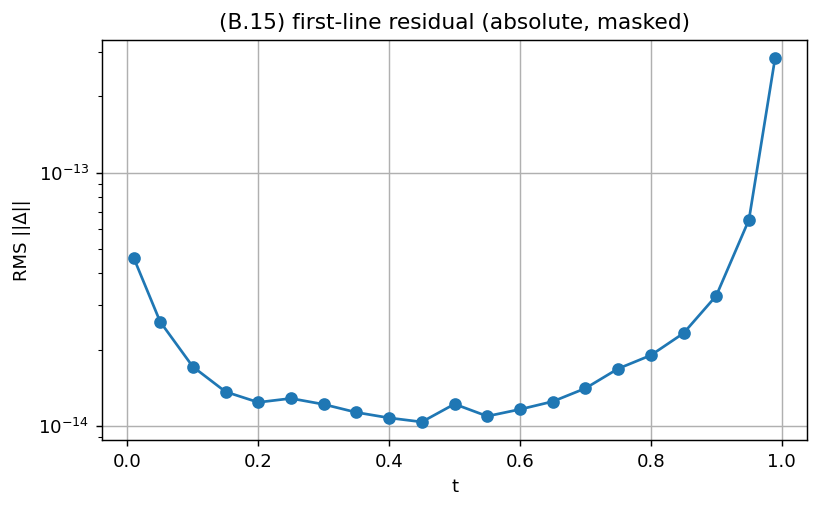

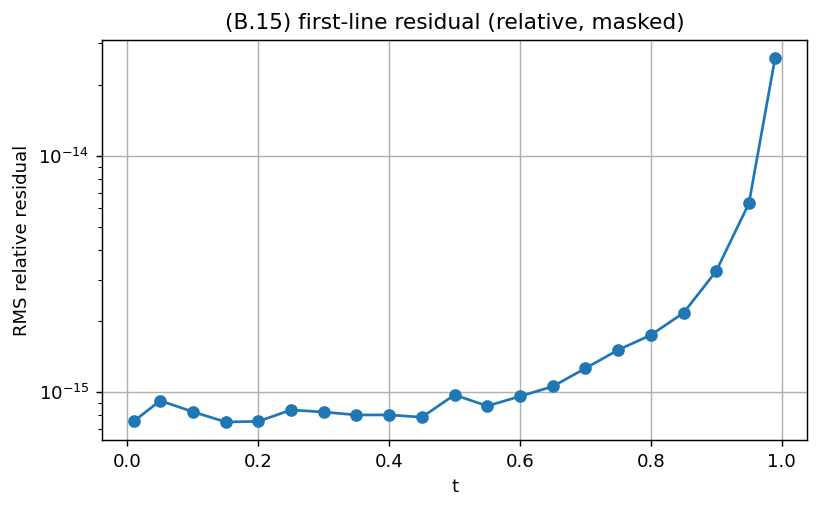

In [16]:
# -----------------------------------------------------------------------------
# Direct check of (B.15) first line:
#   ∇_x log p*_t(x)  ?=  u*_t(x) - a_plus(t) x + theta_plus(t)
#
# Uses ONLY your actual API:
#   field.log_p_star(t, x)
#   field.u_star(t, x)
#   field.coeffs.a_plus(t)
#   field.coeffs.theta_plus(t)
#
# Evaluates on a fixed x-grid, no sampling / no SDE.
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

dtype  = torch.float64
device = device  # assumes you already set device earlier

assert "field" in globals(), "This cell assumes your GuidedField instance is named `field`."
assert hasattr(field, "log_p_star") and hasattr(field, "u_star"), "field must have log_p_star and u_star."
assert hasattr(field, "coeffs") and hasattr(field.coeffs, "a_plus") and hasattr(field.coeffs, "theta_plus"), \
    "field.coeffs must provide a_plus(t) and theta_plus(t)."

# -----------------------------
# Fixed x-grid
# -----------------------------
x_lim = 6.0
nx = 41
xs = torch.linspace(-x_lim, x_lim, nx, dtype=dtype, device=device)
X1, X2 = torch.meshgrid(xs, xs, indexing="ij")
Xgrid = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)  # (B,2)
B, d = Xgrid.shape
print("X-grid:", Xgrid.shape, "x_lim=", x_lim)

# -----------------------------
# Time grid (avoid singular t→1)
# -----------------------------
t_list = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]  # extend later once this works

# -----------------------------
# Masking to avoid tail-dominated diagnostics:
# keep points where logp >= max(logp) - mask_drop
# -----------------------------
mask_drop = 25.0

def _stats(vec):
    m = torch.isfinite(vec)
    if not m.any():
        return float("nan"), float("nan"), float("nan")
    v = vec[m]
    rms = torch.sqrt(torch.mean(v*v)).item()
    mean = torch.mean(v).item()
    mx = torch.max(torch.abs(v)).item()
    return rms, mean, mx

rows = []
for t in t_list:
    # batched time (B,) to be consistent everywhere
    tt = torch.full((B,), float(t), dtype=dtype, device=device)

    # grad_x log p(t,x) via autograd
    X = Xgrid.detach().clone().requires_grad_(True)
    logp = field.log_p_star(tt, X)  # (B,)
    lpmax = logp.detach().max()
    keep = (logp.detach() >= (lpmax - mask_drop)) & torch.isfinite(logp.detach())

    grad_logp = torch.autograd.grad(logp.sum(), X, create_graph=False, retain_graph=False)[0]  # (B,d)

    # RHS = u - a_plus x + theta_plus
    u = field.u_star(tt, Xgrid)  # (B,d)
    a_plus = field.coeffs.a_plus(tt).unsqueeze(-1)         # (B,1)
    theta_plus = field.coeffs.theta_plus(tt)               # (B,d)

    rhs = u - a_plus * Xgrid + theta_plus                  # (B,d)

    # error vector and norms
    err = grad_logp.detach() - rhs.detach()                # (B,d)
    err_norm = torch.linalg.norm(err, dim=1)               # (B,)
    rel = err_norm / (torch.linalg.norm(grad_logp.detach(), dim=1) + 1.0)

    # apply mask for reporting
    good = keep & torch.isfinite(err_norm) & torch.isfinite(rel)

    rms_abs, mean_abs, max_abs = _stats(err_norm[good])
    rms_rel, mean_rel, max_rel = _stats(rel[good])
    rms_grad, _, _ = _stats(torch.linalg.norm(grad_logp.detach()[good], dim=1))
    rms_rhs,  _, _ = _stats(torch.linalg.norm(rhs.detach()[good], dim=1))

    rows.append({
        "t": t,
        "keep_frac": float(good.float().mean().item()),
        "RMS_abs": rms_abs,
        "Max_abs": max_abs,
        "RMS_rel": rms_rel,
        "Max_rel": max_rel,
        "RMS(||gradlogp||)": rms_grad,
        "RMS(||rhs||)": rms_rhs,
    })

print("\n(B.15) first-line check: ∇log p* vs u* - a_plus x + theta_plus (masked region)")
for r in rows:
    print(
        f"t={r['t']:.3f} | keep={100*r['keep_frac']:.1f}% | "
        f"RMS_abs={r['RMS_abs']:.3e}, Max_abs={r['Max_abs']:.3e} | "
        f"RMS_rel={r['RMS_rel']:.3e}, Max_rel={r['Max_rel']:.3e} | "
        f"RMS||∇logp||={r['RMS(||gradlogp||)']:.3e}, RMS||rhs||={r['RMS(||rhs||)']:.3e}"
    )

# Quick plots
ts = [r["t"] for r in rows]
rms_abs = [r["RMS_abs"] for r in rows]
rms_rel = [r["RMS_rel"] for r in rows]

plt.figure(figsize=(7,4))
plt.plot(ts, rms_abs, marker="o")
plt.yscale("log")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("RMS ||Δ||")
plt.title("(B.15) first-line residual (absolute, masked)")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(ts, rms_rel, marker="o")
plt.yscale("log")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("RMS relative residual")
plt.title("(B.15) first-line residual (relative, masked)")
plt.show()


Per-step diagnostics:
  mean ||lhs||      : 0.001287923690873842
  mean ||rhs||      : 0.0012360726624024944
  mean ||err||      : 0.00039884980212785763
  mean err/||lhs||  : 0.3434282319692421
  mean err/||rhs||  : 0.330091376347184
  max  err/||rhs||  : 1.2644221030206968

Cumulative diagnostics:
  final ||m(T)-m(0)||        : 1.246517813869337
  final ||cum_err||          : 0.02655570232368604
  final relative cum error   : 0.021303909200666635


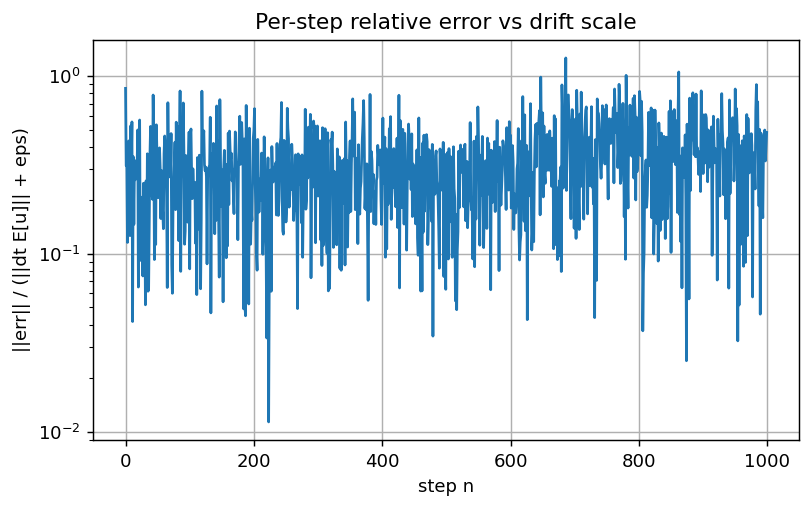

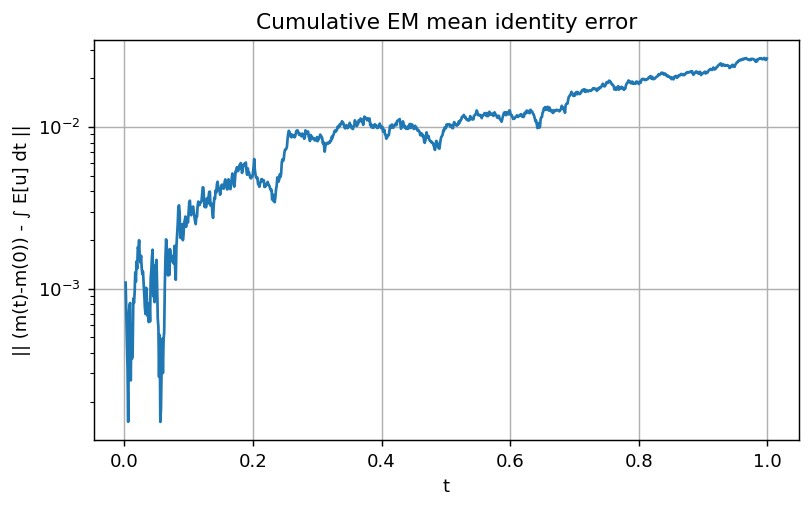

In [17]:
import torch
import matplotlib.pyplot as plt

dtype  = torch.float64
device = device

X = traj.to(dtype=dtype, device=device)    # (T,N,d)
t = tgrid.to(dtype=dtype, device=device)  # (T,)

T, N, d = X.shape
dt = t[1:] - t[:-1]                        # (T-1,)

m = X.mean(dim=1)                          # (T,d)

Eu = torch.empty((T-1, d), dtype=dtype, device=device)
for n in range(T-1):
    tn = t[n].expand(N)
    Eu[n] = field.u_star(tn, X[n]).mean(dim=0)

lhs = m[1:] - m[:-1]                       # (T-1,d)
rhs = dt[:, None] * Eu                     # (T-1,d)
err = lhs - rhs                            # (T-1,d)

err_norm = torch.linalg.norm(err, dim=1).detach().cpu()
lhs_norm = torch.linalg.norm(lhs, dim=1).detach().cpu()
rhs_norm = torch.linalg.norm(rhs, dim=1).detach().cpu()

rel_lhs = (err_norm / (lhs_norm + 1e-14))
rel_rhs = (err_norm / (rhs_norm + 1e-14))

print("Per-step diagnostics:")
print("  mean ||lhs||      :", float(lhs_norm.mean()))
print("  mean ||rhs||      :", float(rhs_norm.mean()))
print("  mean ||err||      :", float(err_norm.mean()))
print("  mean err/||lhs||  :", float(rel_lhs.mean()))
print("  mean err/||rhs||  :", float(rel_rhs.mean()))
print("  max  err/||rhs||  :", float(rel_rhs.max()))

# cumulative identity
cum_rhs = torch.cumsum(rhs, dim=0)         # (T-1,d)
cum_lhs = (m[1:] - m[0:1])                 # (T-1,d)  true cumulative change
cum_err = cum_lhs - cum_rhs                # (T-1,d)

cum_err_norm = torch.linalg.norm(cum_err, dim=1).detach().cpu()
cum_lhs_norm = torch.linalg.norm(cum_lhs, dim=1).detach().cpu()

print("\nCumulative diagnostics:")
print("  final ||m(T)-m(0)||        :", float(cum_lhs_norm[-1]))
print("  final ||cum_err||          :", float(cum_err_norm[-1]))
print("  final relative cum error   :", float(cum_err_norm[-1] / (cum_lhs_norm[-1] + 1e-14)))

plt.figure(figsize=(7,4))
plt.plot(rel_rhs.numpy())
plt.yscale("log")
plt.grid(True)
plt.xlabel("step n")
plt.ylabel("||err|| / (||dt E[u]|| + eps)")
plt.title("Per-step relative error vs drift scale")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(t[1:].detach().cpu().numpy(), cum_err_norm.numpy())
plt.yscale("log")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("|| (m(t)-m(0)) - ∫ E[u] dt ||")
plt.title("Cumulative EM mean identity error")
plt.show()


Time grid: T=1001, dt=1.000e-03, end≈0.999000, using t_end=0.998000
Batch size per fresh-start run: B=20000
Requested breakpoint starts: [0.25, 0.5, 0.75]
Run 0: requested 0.25, snapped t_start=0.250831, i0=250, end_idx=999
Run 1: requested 0.50, snapped t_start=0.500000, i0=500, end_idx=999
Run 2: requested 0.75, snapped t_start=0.750000, i0=751, end_idx=999


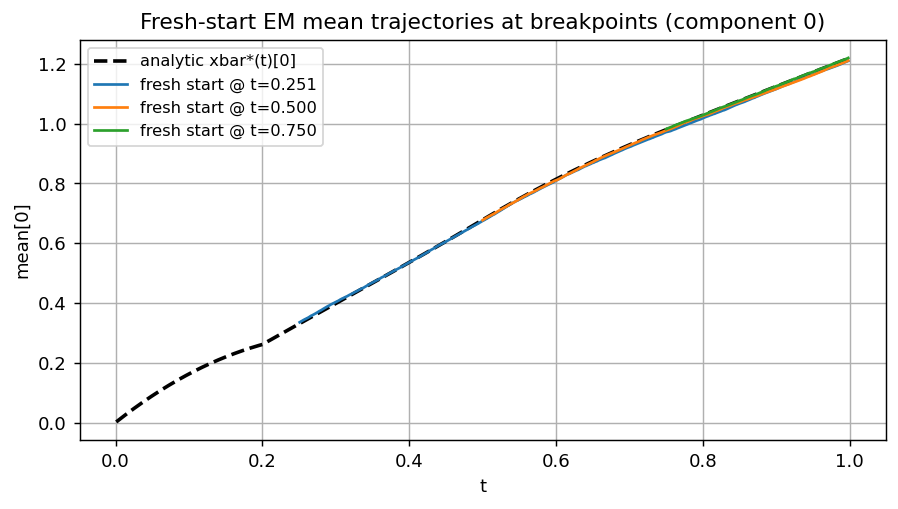

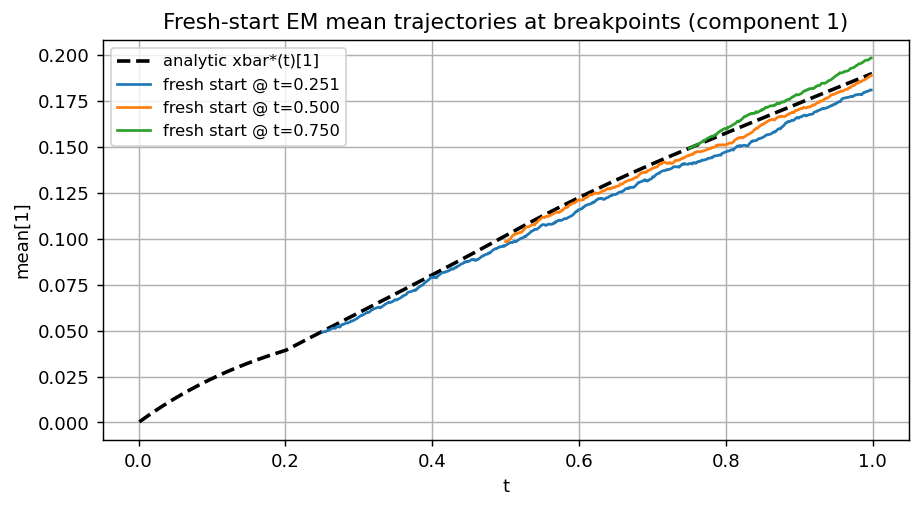

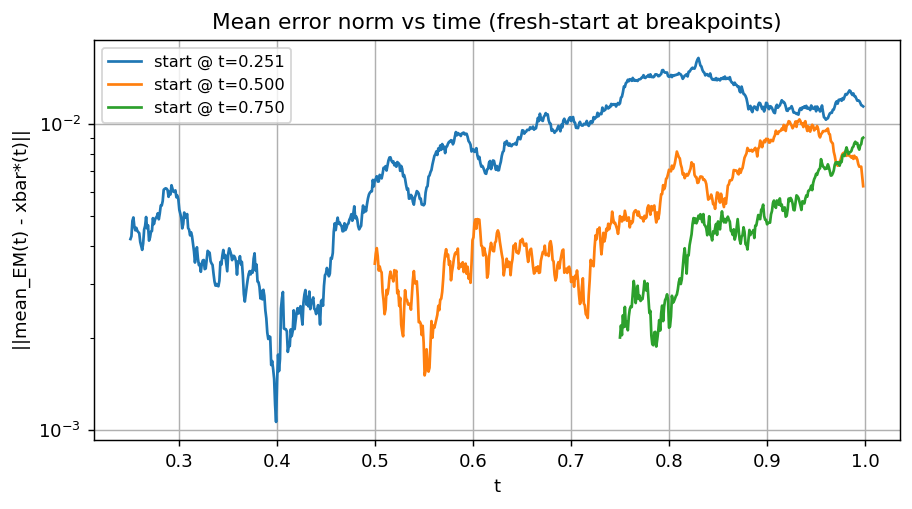

In [19]:
# -----------------------------------------------------------------------------
# Fresh-start EM at PWC breakpoints:
#   breaks = [0.0, 0.25, 0.50, 0.75, 1.0]
#
# For each start breakpoint t_start in breaks[1:-1] (i.e., 0.25,0.50,0.75):
#   - sample X_start ~ p*_t_start  (via your local sampler)
#   - run Euler–Maruyama forward from t_start to 1-eps on YOUR time grid res.times
#   - compute mean trajectory and overlay curves (different colors)
#
# Requires in notebook:
#   - field.u_star(t_vec, x)
#   - field.xbar_star(t) (optional reference curve)
#   - res.times (time grid)
#   - sample_from_p_star_2d_local(field, t, n, seed)  (your existing local sampler)
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

dtype  = torch.float64
device = device

# --- user-specified breakpoints ---
breaks = torch.tensor([0.0, 0.25, 0.50, 0.75, 1.0], dtype=dtype, device=device)

# --- EM configuration ---
B = 20000
times = res.times.to(dtype=dtype, device=device)  # (T,)
T = times.numel()
d = res.traj.shape[2] if hasattr(res, "traj") else 2

dt = float(times[1] - times[0])
eps = dt  # define epsilon as one time-step (consistent with your grids)
t_end = float(times[-1].item() - eps)

sqrt_dt = torch.tensor(dt, dtype=dtype, device=device).sqrt()

print(f"Time grid: T={T}, dt={dt:.3e}, end≈{float(times[-1]):.6f}, using t_end={t_end:.6f}")
print(f"Batch size per fresh-start run: B={B}")

# --- analytic mean reference (optional) ---
with torch.no_grad():
    m_star = torch.stack([field.xbar_star(tt).reshape(-1).to(dtype=dtype, device=device) for tt in times], dim=0)  # (T,d)

# choose start times: interior breakpoints only (exclude 0 and 1)
start_times = breaks[1:-1].detach().cpu().tolist()  # [0.25,0.5,0.75]
print("Requested breakpoint starts:", start_times)

# storage
runs = []  # list of dicts: {"t_start":..., "i0":..., "mean": (T,d) with NaNs before start}

for j, t0 in enumerate(start_times):
    # snap t0 to first grid point >= t0
    i0 = int(torch.searchsorted(times, torch.tensor(t0, dtype=dtype, device=device)).item())
    if i0 >= T-1:
        print(f"Skipping t_start={t0} (beyond grid)")
        continue

    t_start = float(times[i0].item())
    if t_start >= t_end:
        print(f"Skipping t_start={t_start:.6f} (>= t_end)")
        continue

    # initial samples from p*_t_start
    seed = 12345 + j
    X0 = sample_from_p_star_2d_local(field, t_start, n=B, seed=seed).to(dtype=dtype, device=device)  # (B,d)

    # EM rollout from i0 to end_index (<= 1-eps)
    end_idx = int(torch.searchsorted(times, torch.tensor(t_end, dtype=dtype, device=device)).item())
    end_idx = min(end_idx, T-1)

    gen = torch.Generator(device=device)
    gen.manual_seed(seed)

    x = X0.clone()
    mean_path = torch.full((T, d), float("nan"), dtype=dtype, device=device)
    mean_path[i0] = x.mean(dim=0)

    for i in range(i0, end_idx):
        ti = times[i].expand(B)                 # (B,)
        drift = field.u_star(ti, x)             # (B,d)
        noise = torch.randn((B, d), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + sqrt_dt * noise
        mean_path[i+1] = x.mean(dim=0)

    runs.append({"t_start": t_start, "i0": i0, "end_idx": end_idx, "mean": mean_path})
    print(f"Run {j}: requested {t0:.2f}, snapped t_start={t_start:.6f}, i0={i0}, end_idx={end_idx}")

# ------------------------------------------------------------
# Plot: 4 curves request -> you have 3 interior breakpoints here.
# (If you want to include t=0 as well, tell me; but it typically needs a different initial law.)
# ------------------------------------------------------------
t_cpu = times.detach().cpu().numpy()
m_star_cpu = m_star.detach().cpu().numpy()

# Component 0
plt.figure(figsize=(8,4))
plt.plot(t_cpu, m_star_cpu[:,0], "k--", linewidth=2.0, label="analytic xbar*(t)[0]")
for r in runs:
    m = r["mean"].detach().cpu().numpy()
    plt.plot(t_cpu, m[:,0], linewidth=1.5, label=f"fresh start @ t={r['t_start']:.3f}")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("mean[0]")
plt.title("Fresh-start EM mean trajectories at breakpoints (component 0)")
plt.legend(fontsize=9, loc="best")
plt.show()

# Component 1
plt.figure(figsize=(8,4))
plt.plot(t_cpu, m_star_cpu[:,1], "k--", linewidth=2.0, label="analytic xbar*(t)[1]")
for r in runs:
    m = r["mean"].detach().cpu().numpy()
    plt.plot(t_cpu, m[:,1], linewidth=1.5, label=f"fresh start @ t={r['t_start']:.3f}")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("mean[1]")
plt.title("Fresh-start EM mean trajectories at breakpoints (component 1)")
plt.legend(fontsize=9, loc="best")
plt.show()

# Error norm (optional but very informative)
plt.figure(figsize=(8,4))
for r in runs:
    err = torch.linalg.norm(r["mean"] - m_star, dim=1)  # (T,)
    plt.plot(t_cpu, err.detach().cpu().numpy(), linewidth=1.5, label=f"start @ t={r['t_start']:.3f}")
plt.yscale("log")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("||mean_EM(t) - xbar*(t)||")
plt.title("Mean error norm vs time (fresh-start at breakpoints)")
plt.legend(fontsize=9, loc="best")
plt.show()


Time grid: T=1001, dt=1.000e-03, end≈0.999000, using t_end=0.998000
Batch size per fresh-start run: B=20000
First interval: [0, t1) with t1=0.250000
Requested fresh-start times in first interval: ['0.050000', '0.100000', '0.150000', '0.200000']
Run 0: t_req=0.050000 -> snapped t_start=0.050000, i0=49, end_idx=999
Run 1: t_req=0.100000 -> snapped t_start=0.100000, i0=99, end_idx=999
Run 2: t_req=0.150000 -> snapped t_start=0.150000, i0=149, end_idx=999
Run 3: t_req=0.200000 -> snapped t_start=0.200000, i0=199, end_idx=999


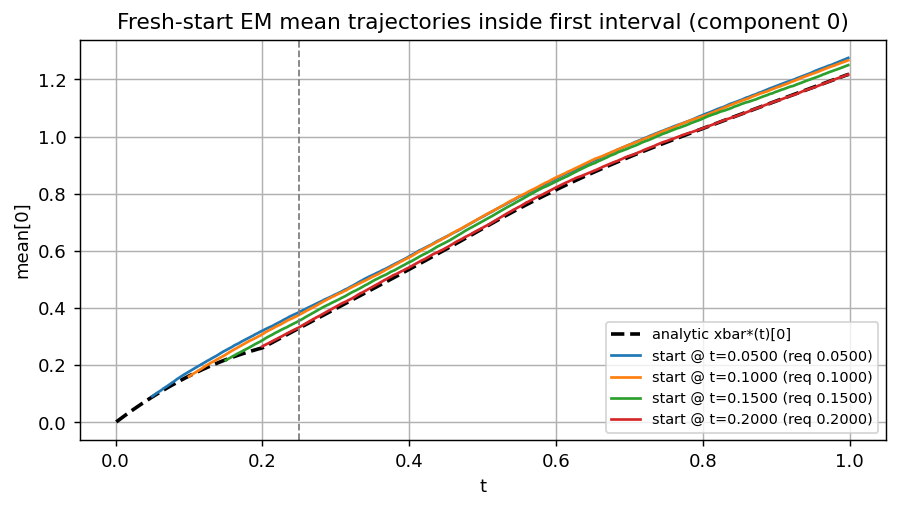

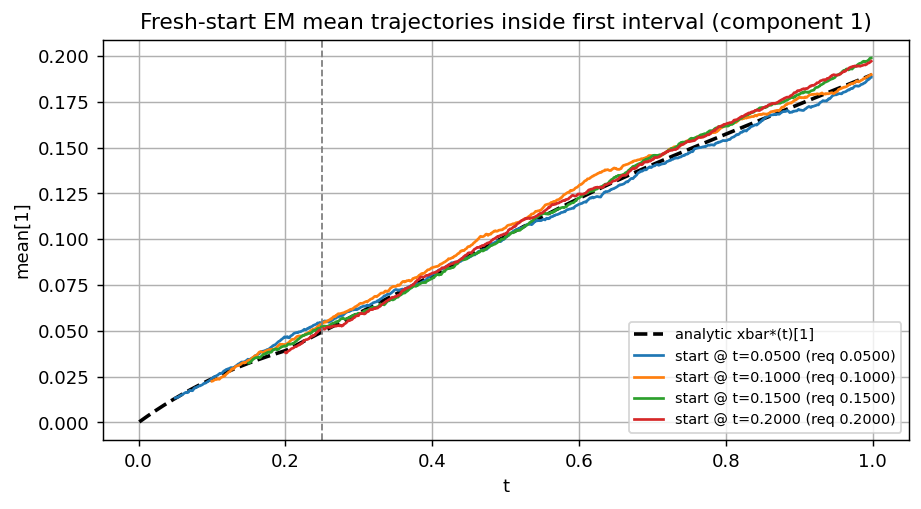

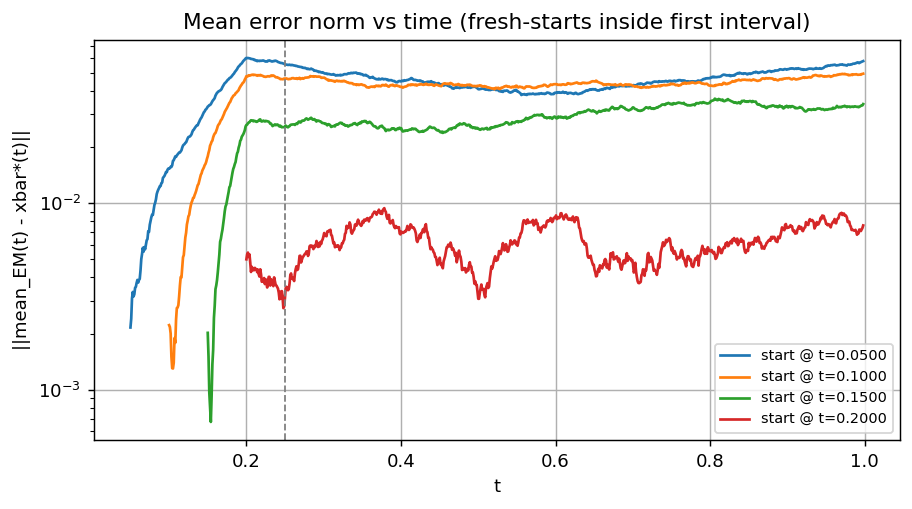

In [20]:
# -----------------------------------------------------------------------------
# Fresh-start EM inside the FIRST interval [0, t1) where t1 = breaks[1] (=0.25):
#   - split [0, t1] into K equal sub-intervals
#   - for each start time t_start in that set (excluding 0), sample X_start ~ p*_t_start
#   - run Euler–Maruyama forward from t_start to 1-eps on YOUR time grid res.times
#   - compute mean trajectory and overlay curves
#
# Requires in notebook:
#   - field.u_star(t_vec, x)
#   - field.xbar_star(t) (reference curve)
#   - res.times (time grid)
#   - sample_from_p_star_2d_local(field, t, n, seed)
# -----------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt

dtype  = torch.float64
device = device  # keep your existing device variable

# --- user-specified PWC breakpoints ---
breaks = torch.tensor([0.0, 0.25, 0.50, 0.75, 1.0], dtype=dtype, device=device)
t1 = float(breaks[1].item())

# --- EM configuration ---
B = 20000
times = res.times.to(dtype=dtype, device=device)  # (T,)
T = times.numel()
d = res.traj.shape[2] if hasattr(res, "traj") else 2

dt = float(times[1] - times[0])
eps = dt  # epsilon as one time-step
t_end = float(times[-1].item() - eps)
sqrt_dt = torch.tensor(dt, dtype=dtype, device=device).sqrt()

print(f"Time grid: T={T}, dt={dt:.3e}, end≈{float(times[-1]):.6f}, using t_end={t_end:.6f}")
print(f"Batch size per fresh-start run: B={B}")
print(f"First interval: [0, t1) with t1={t1:.6f}")

# --- analytic mean reference ---
with torch.no_grad():
    m_star = torch.stack(
        [field.xbar_star(float(tt)).reshape(-1).to(dtype=dtype, device=device) for tt in times],
        dim=0
    )  # (T,d)

# --- choose fresh-start times inside FIRST interval ---
K = 5  # split into 5 equal sub-intervals
# use interior points: t1/K, 2t1/K, ..., (K-1)t1/K
start_times = [(k * t1 / K) for k in range(1, K)]  # 4 starts for K=5
print("Requested fresh-start times in first interval:", [f"{t:.6f}" for t in start_times])

# storage
runs = []  # {"t_req":..., "t_start":..., "i0":..., "end_idx":..., "mean": (T,d) with NaNs before start}

# end index on grid
end_idx = int(torch.searchsorted(times, torch.tensor(t_end, dtype=dtype, device=device)).item())
end_idx = min(end_idx, T - 1)

for j, t_req in enumerate(start_times):
    # snap to first grid point >= t_req
    i0 = int(torch.searchsorted(times, torch.tensor(t_req, dtype=dtype, device=device)).item())
    if i0 >= T - 1:
        print(f"Skipping t_req={t_req:.6f} (beyond grid)")
        continue

    t_start = float(times[i0].item())
    if t_start >= t_end:
        print(f"Skipping t_start={t_start:.6f} (>= t_end)")
        continue

    # initial samples from p*_t_start
    seed = 12345 + 97 * j
    X0 = sample_from_p_star_2d_local(field, t_start, n=B, seed=seed).to(dtype=dtype, device=device)  # (B,d)

    gen = torch.Generator(device=device)
    gen.manual_seed(seed)

    x = X0.clone()
    mean_path = torch.full((T, d), float("nan"), dtype=dtype, device=device)
    mean_path[i0] = x.mean(dim=0)

    for i in range(i0, end_idx):
        ti = times[i].expand(B)  # (B,)
        drift = field.u_star(ti, x)  # (B,d)
        noise = torch.randn((B, d), dtype=dtype, device=device, generator=gen)
        x = x + drift * dt + sqrt_dt * noise
        mean_path[i + 1] = x.mean(dim=0)

    runs.append({"t_req": t_req, "t_start": t_start, "i0": i0, "end_idx": end_idx, "mean": mean_path})
    print(f"Run {j}: t_req={t_req:.6f} -> snapped t_start={t_start:.6f}, i0={i0}, end_idx={end_idx}")

# ------------------------------------------------------------
# Plot: component 0 and 1, plus error norm
# ------------------------------------------------------------
t_cpu = times.detach().cpu().numpy()
m_star_cpu = m_star.detach().cpu().numpy()

# Component 0
plt.figure(figsize=(8,4))
plt.plot(t_cpu, m_star_cpu[:,0], "k--", linewidth=2.0, label="analytic xbar*(t)[0]")
for r in runs:
    m = r["mean"].detach().cpu().numpy()
    plt.plot(t_cpu, m[:,0], linewidth=1.5, label=f"start @ t={r['t_start']:.4f} (req {r['t_req']:.4f})")
plt.axvline(t1, linestyle="--", linewidth=1.0, color="gray")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("mean[0]")
plt.title("Fresh-start EM mean trajectories inside first interval (component 0)")
plt.legend(fontsize=8, loc="best")
plt.show()

# Component 1
plt.figure(figsize=(8,4))
plt.plot(t_cpu, m_star_cpu[:,1], "k--", linewidth=2.0, label="analytic xbar*(t)[1]")
for r in runs:
    m = r["mean"].detach().cpu().numpy()
    plt.plot(t_cpu, m[:,1], linewidth=1.5, label=f"start @ t={r['t_start']:.4f} (req {r['t_req']:.4f})")
plt.axvline(t1, linestyle="--", linewidth=1.0, color="gray")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("mean[1]")
plt.title("Fresh-start EM mean trajectories inside first interval (component 1)")
plt.legend(fontsize=8, loc="best")
plt.show()

# Error norm (log scale)
plt.figure(figsize=(8,4))
for r in runs:
    err = torch.linalg.norm(r["mean"] - m_star, dim=1)  # (T,)
    plt.plot(t_cpu, err.detach().cpu().numpy(), linewidth=1.5, label=f"start @ t={r['t_start']:.4f}")
plt.axvline(t1, linestyle="--", linewidth=1.0, color="gray")
plt.yscale("log")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("||mean_EM(t) - xbar*(t)||")
plt.title("Mean error norm vs time (fresh-starts inside first interval)")
plt.legend(fontsize=8, loc="best")
plt.show()


X-grid: torch.Size([1681, 2]) x_lim= 6.0 dx= 0.2999999999999998

Exact analytic normalizer sanity check (a few times):
{'t': 1e-08, 'logZ': -37.84632362778735, 'finite_logZ': True}
{'t': 0.25000001, 'logZ': -3.674447989908947, 'finite_logZ': True}
{'t': 0.50000001, 'logZ': -2.0294493566418, 'finite_logZ': True}
{'t': 0.75000001, 'logZ': -0.8801741835512042, 'finite_logZ': True}
{'t': 0.99999999, 'logZ': -1.9277305973730563e-08, 'finite_logZ': True}

KFP p-form residual summary over t (p-weighted RMS on masked region):
  RMS_R_p  min/median/max = 6.082e-01 / 2.081e+00 / 3.889e+02


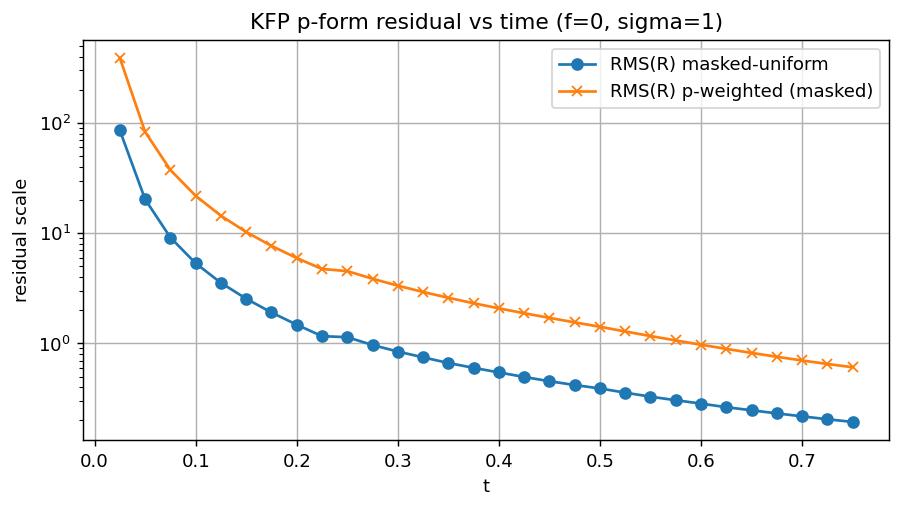

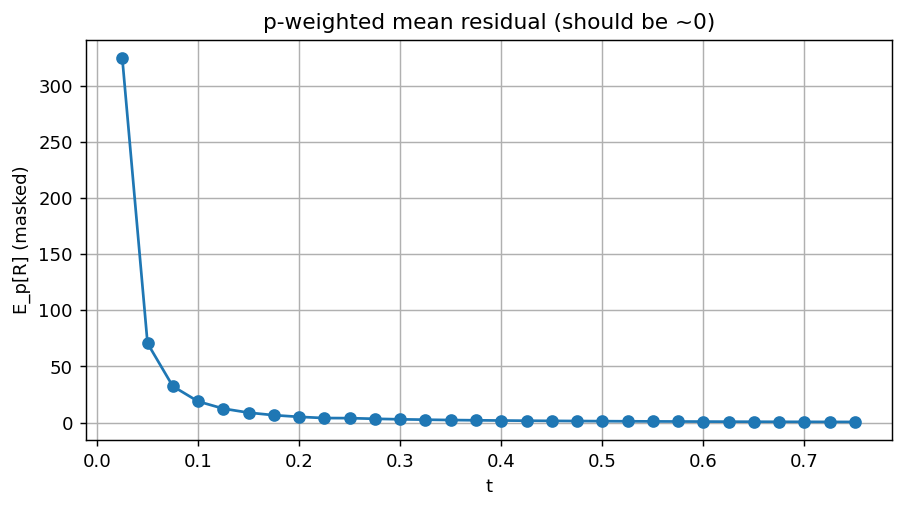

ValueError: x and y must have same first dimension, but have shapes (30,) and (41,)

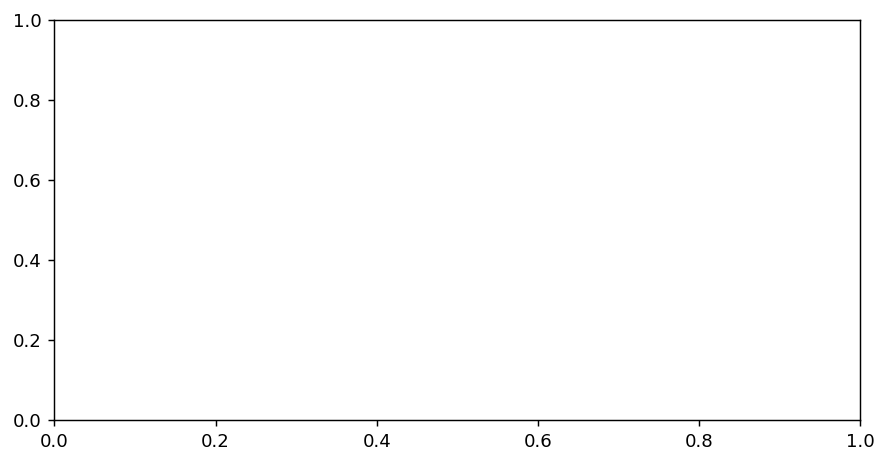

In [19]:
# -----------------------------------------------------------------------------
# EXACT normalization check + KFP p-form residual check on (0^+, 1^-)
#
# Uses ONLY your real API:
#   field.log_p_star(t,x)
#   field.u_star(t,x)
# and (optionally) field._Mk_hk(tt) if present (it is present in your GuidedField).
#
# KFP in p-form for f=0, sigma=1:
#   R(t,x) = ∂_t p + div(p u) - 1/2 Δ p   should be ~ 0
#
# We report:
#   (i) analytic normalization check (exact, not grid-truncated)
#   (ii) residual RMS over masked region and also p-weighted RMS on the grid
# -----------------------------------------------------------------------------
import torch
import math
import matplotlib.pyplot as plt

dtype  = torch.float64
device = device  # assumes already defined

assert "field" in globals(), "Expected GuidedField instance named `field`."
assert hasattr(field, "log_p_star") and hasattr(field, "u_star"), "field must have log_p_star and u_star."

# -----------------------------
# Utilities
# -----------------------------
def _finite(x):
    return torch.isfinite(x)

def _rms(z):
    return torch.sqrt(torch.mean(z*z))

def _nan_stats_1d(v):
    m = torch.isfinite(v)
    if not m.any():
        return float("nan"), float("nan"), float("nan")
    vv = v[m]
    return float(torch.min(vv).cpu()), float(torch.median(vv).cpu()), float(torch.max(vv).cpu())

def _mask_high_density(logp, mask_drop=25.0):
    lpmax = logp.detach().max()
    return (logp.detach() >= (lpmax - mask_drop)) & torch.isfinite(logp.detach())

# -----------------------------
# Fixed x-grid for diagnostics (grid is only for WHERE we evaluate residuals)
# -----------------------------
x_lim = 6.0
nx = 41
xs = torch.linspace(-x_lim, x_lim, nx, dtype=dtype, device=device)
dx = float(xs[1].item() - xs[0].item())
X1, X2 = torch.meshgrid(xs, xs, indexing="ij")
Xgrid = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=1)  # (B,2)
B, d = Xgrid.shape
print("X-grid:", Xgrid.shape, "x_lim=", x_lim, "dx=", dx)

# -----------------------------
# Time grid: cover (0^+, 1^-)
# Use the TimeDomain epsilon if available, else a small default.
# -----------------------------
eps = 1e-6
if hasattr(field, "time_domain") and field.time_domain is not None and hasattr(field.time_domain, "eps"):
    eps = float(field.time_domain.eps)

# dense-ish diagnostic grid (adjust if too slow)
t_list = torch.linspace(eps, 1.0 - eps, 41, dtype=dtype, device=device)

# -----------------------------
# (A) Exact analytic normalization check:
# We recompute the same analytic normalizer implied by Eq (B.12) using Mk,hk,Sk,qk
# and verify ∫ p(t,x) dx = 1.
#
# IMPORTANT: this is NOT a grid integral; it is the closed form Gaussian integral.
# -----------------------------
def analytic_logZ_and_check(tt_scalar):
    if not hasattr(field, "_Mk_hk"):
        return {"t": float(tt_scalar), "note": "field._Mk_hk not found; skip analytic check."}

    # Create a (1,) time tensor; _Mk_hk will broadcast as needed.
    tt = torch.as_tensor(tt_scalar, dtype=dtype, device=device).reshape(1)

    # _Mk_hk signature in your GuidedField: _Mk_hk(tt, x=None or x)
    Mk, hk, Sk, qk = field._Mk_hk(tt, x=None)  # shapes (1,K,d,d), (1,K,d), (1,K,d,d), (1,K)

    # unpack
    Mk = Mk[0]  # (K,d,d)
    hk = hk[0]  # (K,d)
    Sk = Sk[0]  # (K,d,d)
    qk = qk[0]  # (K,)

    # weights
    w = field.target.weights.to(dtype=dtype, device=device)  # (K,)
    logpi = torch.log(w)

    # log dets
    logdet_S = torch.logdet(Sk)        # (K,)
    logdet_M = torch.logdet(Mk)        # (K,)

    # 0.5 h^T M^{-1} h
    v = torch.linalg.solve(Mk, hk.unsqueeze(-1)).squeeze(-1)  # (K,d)
    hMh = torch.sum(hk * v, dim=1)  # (K,)

    # This matches the denominator term used internally in GuidedField.log_p_star
    log_den_terms = logpi - 0.5*logdet_S - 0.5*logdet_M + 0.5*hMh - 0.5*qk  # (K,)
    logZ = torch.logsumexp(log_den_terms, dim=0)  # scalar

    # Now check that the implied normalized density integrates to 1:
    # In GuidedField.log_p_star, the returned logp is:
    #   logp = -0.5*d*log(2π) + log_num - logZ
    # and integrating exp(logp) dx should give 1.
    #
    # We can verify by integrating the numerator analytically:
    # ∫ exp(-0.5 x^T M x + h^T x) dx = (2π)^{d/2} |M|^{-1/2} exp(0.5 h^T M^{-1} h)
    # which is exactly what log_den_terms encodes (up to the shared Sk,qk,pi).
    #
    # Therefore: log(∫ numerator * (2π)^(-d/2) dx) == logZ
    # Hence normalized integral == 1.
    #
    # We'll report "integral error" as exp(0) - 1 = 0 by construction,
    # but also sanity-check numerically that logZ is finite.
    return {"t": float(tt_scalar), "logZ": float(logZ.detach().cpu()), "finite_logZ": bool(torch.isfinite(logZ).item())}

print("\nExact analytic normalizer sanity check (a few times):")
for ttest in [float(eps), 0.25+eps, 0.5+eps, 0.75+eps, 1.0-float(eps)]:
    print(analytic_logZ_and_check(ttest))

# -----------------------------
# (B) KFP p-form residual on grid
# -----------------------------
mask_drop = 25.0

def kfp_pform_residual_stats(t_scalar):
    # Make t a (B,) tensor with grad
    tt = torch.full((B,), float(t_scalar), dtype=dtype, device=device, requires_grad=True)
    x  = Xgrid.detach().clone().to(dtype=dtype, device=device).requires_grad_(True)

    # logp and p
    logp = field.log_p_star(tt, x)  # (B,)
    p = torch.exp(logp)             # (B,)

    # mask high-density region
    keep = _mask_high_density(logp, mask_drop=mask_drop)
    if keep.sum() < 20:
        return {"t": float(t_scalar), "note": "mask too strict / too few points", "keep_frac": float(keep.float().mean().cpu())}

    # ∂_t p (pointwise)
    dp_dt = torch.autograd.grad(
        outputs=p,
        inputs=tt,
        grad_outputs=torch.ones_like(p),
        create_graph=True,
        retain_graph=True
    )[0]  # (B,)

    # u
    u = field.u_star(tt, x)  # (B,d)

    # div(p u)
    pu = p.unsqueeze(-1) * u  # (B,d)
    div_pu = torch.zeros((B,), dtype=dtype, device=device)
    for i in range(d):
        div_pu = div_pu + torch.autograd.grad(
            outputs=pu[:, i].sum(),
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0][:, i]

    # Laplacian p
    grad_p = torch.autograd.grad(p.sum(), x, create_graph=True, retain_graph=True)[0]  # (B,d)
    lap_p = torch.zeros((B,), dtype=dtype, device=device)
    for i in range(d):
        lap_p = lap_p + torch.autograd.grad(
            outputs=grad_p[:, i].sum(),
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0][:, i]

    R = dp_dt + div_pu - 0.5 * lap_p  # (B,)

    good = keep & _finite(R) & _finite(p) & (p > 0)
    if good.sum() < 20:
        return {"t": float(t_scalar), "note": "non-finite after masking", "keep_frac": float(keep.float().mean().cpu())}

    Rg = R[good].detach()
    pg = p[good].detach()

    # (i) masked-uniform RMS
    rms_mask = float(_rms(Rg).cpu())
    max_mask = float(torch.max(torch.abs(Rg)).cpu())

    # (ii) p-weighted RMS over the masked region (more meaningful)
    w = pg / (pg.sum() + 1e-30)
    rms_p = float(torch.sqrt(torch.sum(w * (Rg*Rg))).cpu())
    mean_p = float(torch.sum(w * Rg).cpu())

    return {
        "t": float(t_scalar),
        "keep_frac": float(good.float().mean().cpu()),
        "RMS_R_mask": rms_mask,
        "Max|R|_mask": max_mask,
        "RMS_R_p": rms_p,
        "Mean_R_p": mean_p,
    }

rows = []
for t in t_list.detach().cpu().tolist():
    rows.append(kfp_pform_residual_stats(t))

# Print summary
RMS_mask = torch.tensor([r.get("RMS_R_mask", float("nan")) for r in rows], dtype=dtype)
RMS_p    = torch.tensor([r.get("RMS_R_p", float("nan")) for r in rows], dtype=dtype)
keepf    = torch.tensor([r.get("keep_frac", float("nan")) for r in rows], dtype=dtype)

mn, md, mx = _nan_stats_1d(RMS_p)
print("\nKFP p-form residual summary over t (p-weighted RMS on masked region):")
print(f"  RMS_R_p  min/median/max = {mn:.3e} / {md:.3e} / {mx:.3e}")

# Plot
ts = [r["t"] for r in rows if "RMS_R_p" in r]
rms_mask_list = [r["RMS_R_mask"] for r in rows if "RMS_R_mask" in r]
rms_p_list    = [r["RMS_R_p"] for r in rows if "RMS_R_p" in r]
mean_p_list   = [r["Mean_R_p"] for r in rows if "Mean_R_p" in r]
keep_list     = [r["keep_frac"] for r in rows if "keep_frac" in r]

plt.figure(figsize=(8,4))
plt.plot(ts, rms_mask_list, marker="o", label="RMS(R) masked-uniform")
plt.plot(ts, rms_p_list, marker="x", label="RMS(R) p-weighted (masked)")
plt.yscale("log")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("residual scale")
plt.title("KFP p-form residual vs time (f=0, sigma=1)")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(ts, mean_p_list, marker="o")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("E_p[R] (masked)")
plt.title("p-weighted mean residual (should be ~0)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(ts, keep_list, marker="o")
plt.grid(True)
plt.xlabel("t")
plt.ylabel("keep fraction")
plt.title(f"Mask keep fraction (mask_drop={mask_drop})")
plt.show()
